In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import shap

np.random.seed(42)
random.seed(42)


In [2]:
import os, pickle

base_dir = "variables_all_mouse/day_outputs"
day_outputs = {}

for fname in os.listdir(base_dir):
    if not fname.endswith(".pkl"):
        continue
    mouse = fname.split(".")[0]
    path  = os.path.join(base_dir, fname)

    mouse_data = pd.read_pickle(path)
    day_outputs[mouse] = mouse_data

print("Loaded day_outputs for mice:", list(day_outputs.keys()))


Loaded day_outputs for mice: ['M9_day_outputs', 'M8_day_outputs', 'M11_day_outputs', 'M23_day_outputs', 'M28_day_outputs']


In [3]:
raw = day_outputs  

day_outputs_flat = {}
for outer_key, nested in raw.items():
    if isinstance(nested, dict) and len(nested)==1:
        real_mouse = next(iter(nested))        # e.g. 'NN9'
        day_outputs_flat[real_mouse] = nested[real_mouse]
    else:
        day_outputs_flat[outer_key] = nested

day_outputs = day_outputs_flat

print("Now day_outputs keys:", list(day_outputs.keys()))


Now day_outputs keys: ['NN9', 'NN8', 'NN11', 'NN23', 'NN28']


In [41]:
learning_signal = {}

for mouse, day_dict in day_outputs.items():
    learning_signal[mouse] = {}

    for date, out in day_dict.items():
        m1 = out['mean_activity_cs_1']
        m2 = out['mean_activity_cs_2']
        r1 = out['mean_activity_r_1']
        r2 = out['mean_activity_r_2']
        trial_r1 = out['trial_r_1']
        trial_r2 = out['trial_r_2']
        r_any = out['mean_activity_r_any']

        r1_norm = r1 / np.mean(r_any, axis=0)
        r2_norm = r2 / np.mean(r_any, axis=0)

        reacts1 = m1[trial_r1]   
        reacts2 = m2[trial_r2] 
        stim_cs1 = r1_norm - reacts1
        stim_cs2 = r2_norm - reacts2

        print(reacts1.shape, stim_cs1.shape)
        print(reacts2.shape, stim_cs2.shape)

        learning_signal[mouse][date] = {
        'mean_activity_cs_1': reacts1,
        'mean_activity_r_1': stim_cs1,
        'mean_activity_cs_2': reacts2,
        'mean_activity_r_2': stim_cs2,
        'trial_r_1': trial_r1,
        'trial_r_2': trial_r2
        }

(18, 2713) (18, 2713)
(20, 2713) (20, 2713)
(41, 2402) (41, 2402)
(22, 2402) (22, 2402)
(25, 1770) (25, 1770)
(29, 1770) (29, 1770)
(19, 1727) (19, 1727)
(28, 1727) (28, 1727)
(14, 4134) (14, 4134)
(15, 4134) (15, 4134)
(20, 3584) (20, 3584)
(9, 3584) (9, 3584)
(17, 2434) (17, 2434)
(9, 2434) (9, 2434)
(53, 1667) (53, 1667)
(35, 1667) (35, 1667)
(56, 1292) (56, 1292)
(27, 1292) (27, 1292)
(49, 2370) (49, 2370)
(26, 2370) (26, 2370)
(63, 2128) (63, 2128)
(47, 2128) (47, 2128)
(67, 1703) (67, 1703)
(52, 1703) (52, 1703)
(49, 1303) (49, 1303)
(28, 1303) (28, 1303)
(8, 3892) (8, 3892)
(29, 3892) (29, 3892)
(45, 2682) (45, 2682)
(48, 2682) (48, 2682)
(53, 1811) (53, 1811)
(60, 1811) (60, 1811)
(35, 1676) (35, 1676)
(42, 1676) (42, 1676)
(34, 1386) (34, 1386)
(38, 1386) (38, 1386)
(32, 2152) (32, 2152)
(12, 2152) (12, 2152)
(15, 2820) (15, 2820)
(32, 2820) (32, 2820)
(27, 2197) (27, 2197)
(30, 2197) (30, 2197)
(39, 913) (39, 913)
(50, 913) (50, 913)
(31, 1277) (31, 1277)
(44, 1277) (44, 1277

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import umap
from umap.umap_ import UMAP

def dim_red_plot(cats: dict, title: str, method: str = 'pca',
                 alpha_min: float = 0.3, alpha_max: float = 1.0):
    # Stack data
    labels = list(cats.keys())
    blocks = [cats[lbl] for lbl in labels]
    lengths = [b.shape[0] for b in blocks]
    X = np.vstack(blocks)

    # Impute & standardize
    X_imp = SimpleImputer(strategy='mean').fit_transform(X)
    Xs    = StandardScaler().fit_transform(X_imp)

    # Dim reduction
    if method == 'pca':
        model = PCA(n_components=2)
        proj  = model.fit_transform(Xs)
    elif method == 'tsne':
        X50   = PCA(n_components=50, random_state=42).fit_transform(Xs)
        model = TSNE(n_components=2, perplexity=30, learning_rate=200,
                     init='pca', n_iter=2000, random_state=42)
        proj  = model.fit_transform(X50)
    elif method == 'umap':
        model = UMAP(n_neighbors=50, min_dist=0.1, random_state=42)
        proj  = model.fit_transform(Xs)
    else:
        raise ValueError("method must be 'pca', 'tsne' or 'umap'")

    # Plot
    cmap = plt.get_cmap('tab10')
    base_colors = {'CS1': cmap(0), 'Learning signal cs1': cmap(1),
                   'CS2': cmap(2), 'Learning signal cs2': cmap(3)}
    plt.figure(figsize=(6,6))
    start = 0
    for lbl, length in zip(labels, lengths):
        seg = proj[start:start+length]
        alphas = np.linspace(alpha_min, alpha_max, length)
        rgb = mpl.colors.to_rgb(base_colors.get(lbl, 'k'))
        colors = [(*rgb, a) for a in alphas]
        plt.scatter(seg[:,0], seg[:,1], c=colors, s=15, label=lbl)
        start += length

    plt.title(title)
    plt.xlabel(f"{method.upper()} dim 1")
    plt.ylabel(f"{method.upper()} dim 2")
    plt.legend(frameon=False)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, proj

results = {'per_mouse': {}, 'grand': {}}


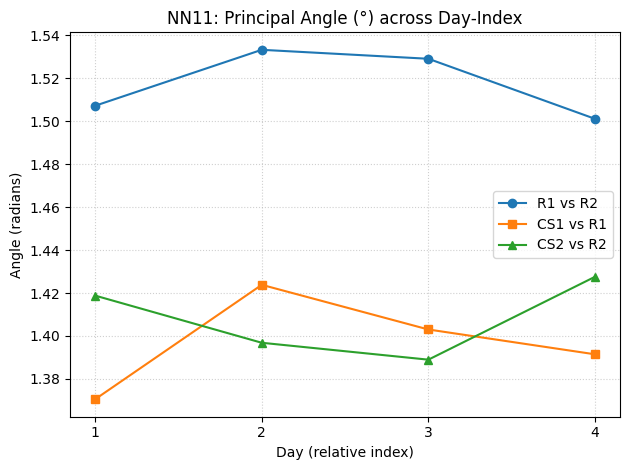

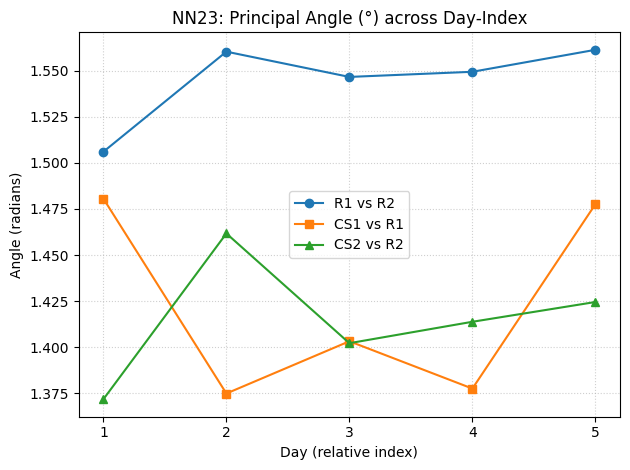

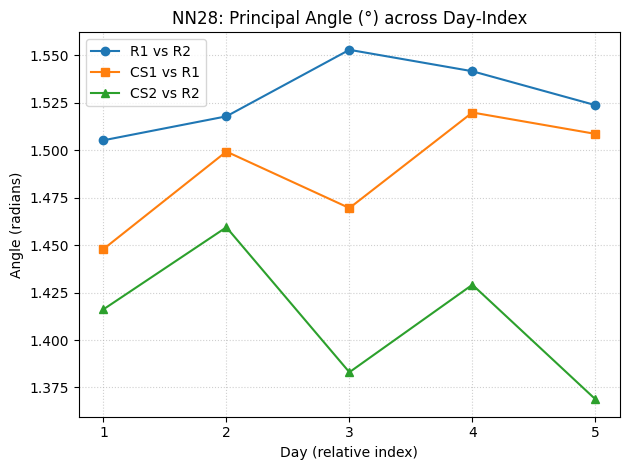

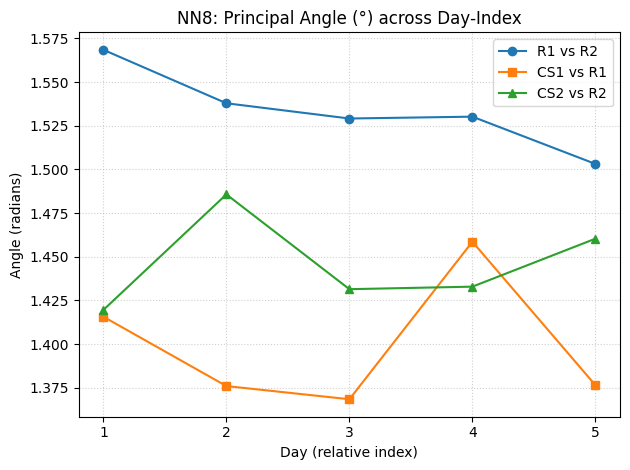

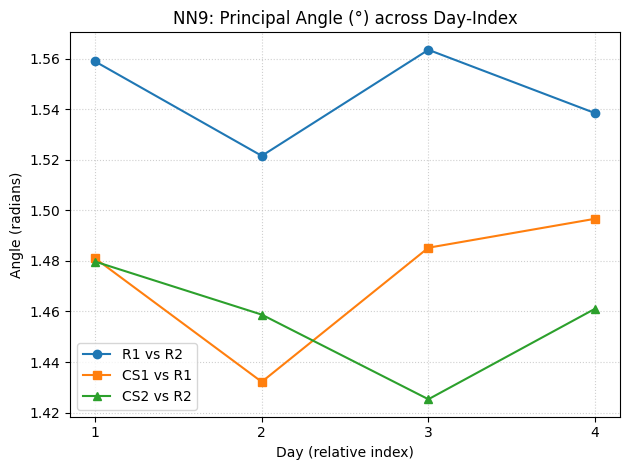

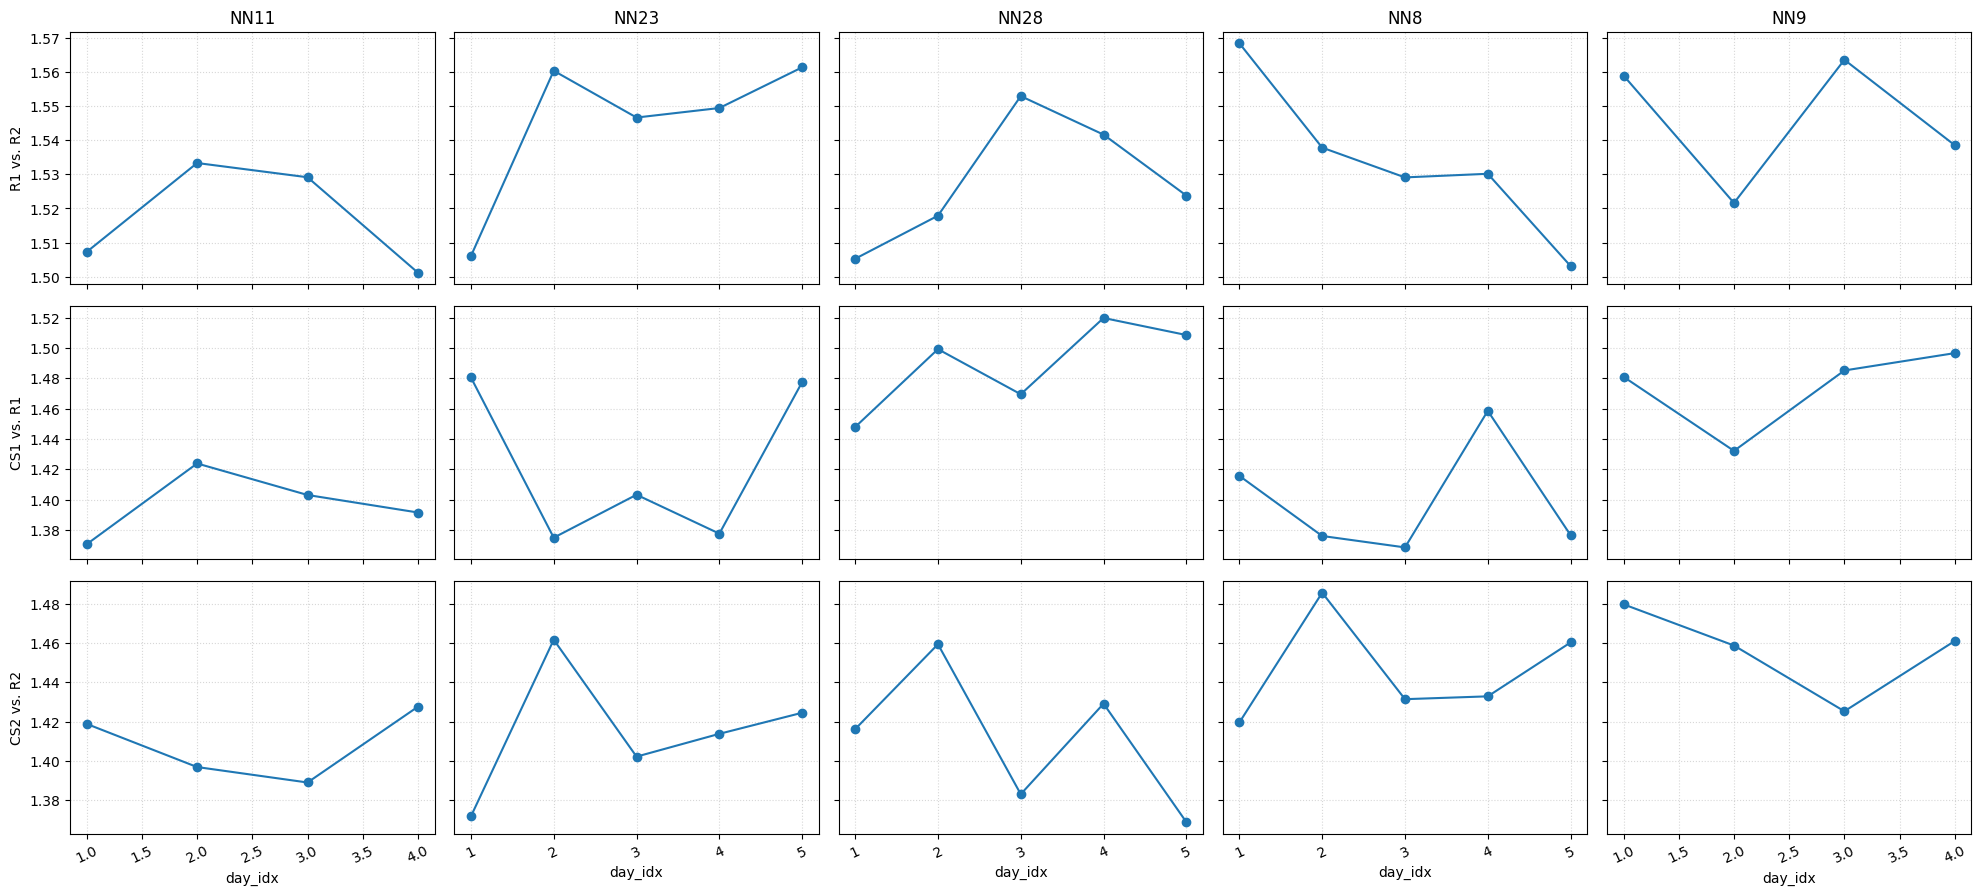

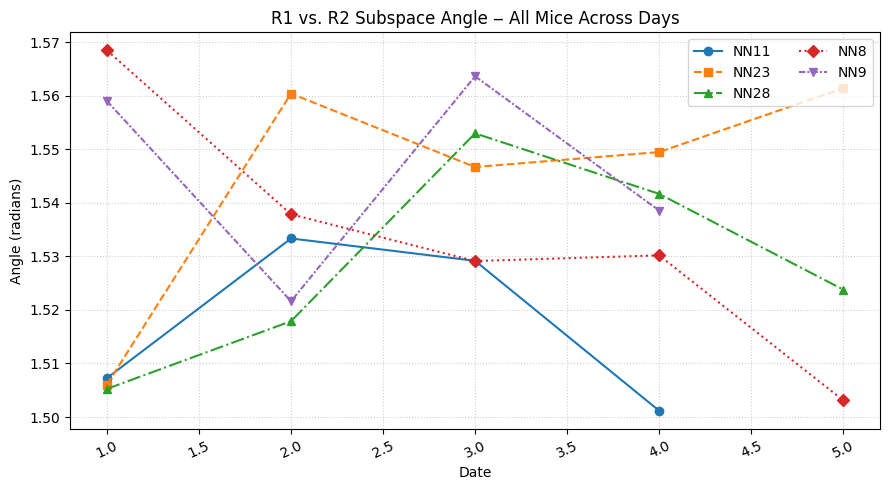

In [51]:
from scipy.linalg import subspace_angles

angles_results = {}
for mouse, day_dict in learning_signal.items():
        angles_results[mouse] = {}

        for date, out in day_dict.items():
                m1 = out['mean_activity_cs_1']
                m2 = out['mean_activity_cs_2']
                r1 = out['mean_activity_r_1']
                r2 = out['mean_activity_r_2']                
                angles_R1_R2 = subspace_angles(r1.T, r2.T)
                angles_CS1_R1 = subspace_angles(m1.T, r1.T)
                angles_CS2_R2 = subspace_angles(m2.T, r2.T)

                angles_results[mouse][date] = {
                       'angles_R1_R2': angles_R1_R2,
                       'angles_CS1_R1': angles_CS1_R1,
                        'angles_CS2_R2': angles_CS2_R2
                }

records = []
for mouse, day_dict in angles_results.items():
    for date, vals in day_dict.items():
        ang_R1R2   = vals['angles_R1_R2'][0]
        ang_CS1R1  = vals['angles_CS1_R1'][0]
        ang_CS2R2  = vals['angles_CS2_R2'][0]


        records.append({
            'mouse':         mouse,
            'date':          date,
            'angle_R1_R2':   ang_R1R2,
            'angle_CS1_R1':  ang_CS1R1,
            'angle_CS2_R2':  ang_CS2R2
        })

df_angles = pd.DataFrame.from_records(records)



    
df_angles['day_idx'] = df_angles.groupby('mouse')['date'].rank(method='dense').astype(int)

for mouse, df_mouse in df_angles.groupby('mouse'):
    plt.figure()
    plt.plot(df_mouse['day_idx'], df_mouse['angle_R1_R2'], marker='o', label='R1 vs R2')
    plt.plot(df_mouse['day_idx'], df_mouse['angle_CS1_R1'], marker='s', label='CS1 vs R1')
    plt.plot(df_mouse['day_idx'], df_mouse['angle_CS2_R2'], marker='^', label='CS2 vs R2')
    plt.title(f"{mouse}: Principal Angle (°) across Day‐Index")
    plt.xlabel("Day (relative index)")
    plt.ylabel("Angle (radians)")
    plt.xticks(df_mouse['day_idx'])  # show every integer day
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

n_mice = df_angles['mouse'].nunique()
mice_list = sorted(df_angles['mouse'].unique())
angle_names = ['angle_R1_R2', 'angle_CS1_R1', 'angle_CS2_R2']
angle_labels = ['R1 vs. R2', 'CS1 vs. R1', 'CS2 vs. R2']

fig, axes = plt.subplots(
    nrows=3, 
    ncols=n_mice, 
    figsize=(4*n_mice, 3*3), 
    sharex='col', 
    sharey='row'
)

for col, mouse in enumerate(mice_list):
    df_mouse = df_angles[df_angles['mouse'] == mouse]
    for row, (angle_key, angle_label) in enumerate(zip(angle_names, angle_labels)):
        ax = axes[row, col]
        ax.plot(
            df_mouse['day_idx'], 
            df_mouse[angle_key], 
            marker='o', 
            linestyle='-'
        )
        if col == 0:
            ax.set_ylabel(angle_label, fontsize=10)
        if row == 0:
            ax.set_title(mouse, fontsize=12)
        if row == 2:
            ax.set_xlabel("day_idx")
        ax.grid(True, linestyle=':', alpha=0.5)
        # rotate only bottom row x‐tick labels
        if row == 2:
            for tick in ax.get_xticklabels():
                tick.set_rotation(25)

plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))

markers = ['o', 's', '^', 'D', 'v', 'P', 'X']  # cycle through these if more than 1 mouse
linestyles = ['-', '--', '-.', ':', (0, (3,1,1,1)), (0, (5,1))]

for (i, (mouse, df_mouse)) in enumerate(df_angles.groupby('mouse')):
    m      = markers[i % len(markers)]
    ls     = linestyles[i % len(linestyles)]
    plt.plot(
        df_mouse['day_idx'], 
        df_mouse['angle_R1_R2'], 
        marker=m, 
        linestyle=ls, 
        label=mouse
    )

plt.title("R1 vs. R2 Subspace Angle ‒ All Mice Across Days")
plt.xlabel("Date")
plt.ylabel("Angle (radians)")
plt.xticks(rotation=25)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()






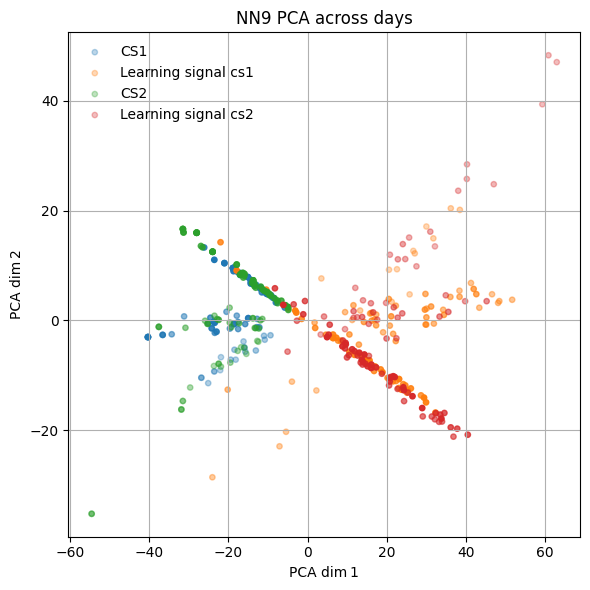

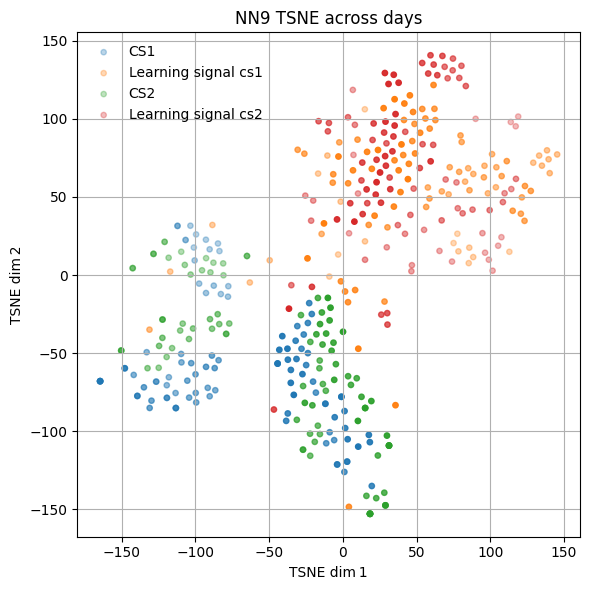

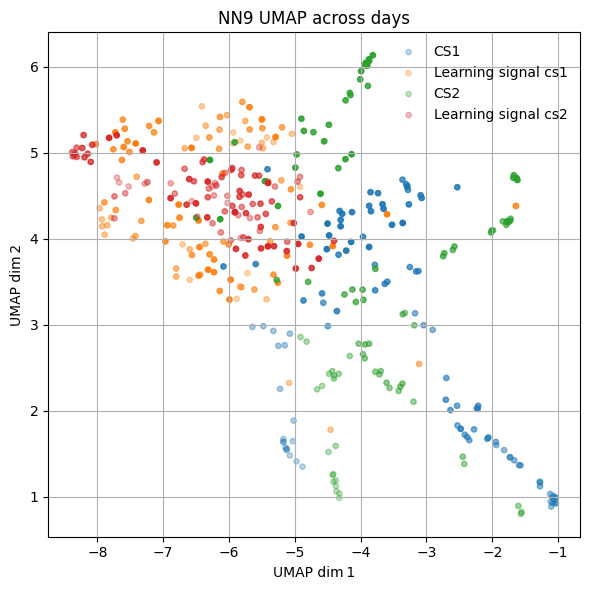

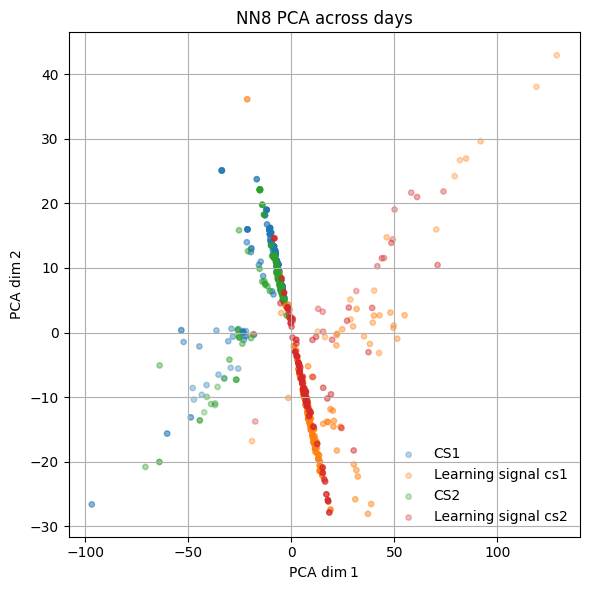

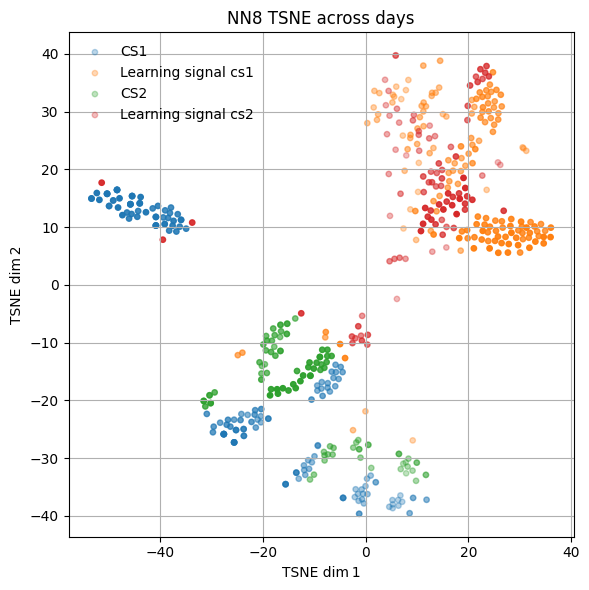

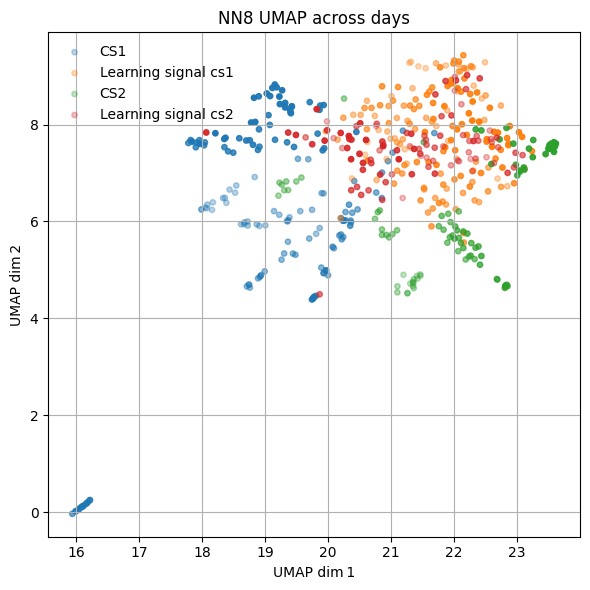

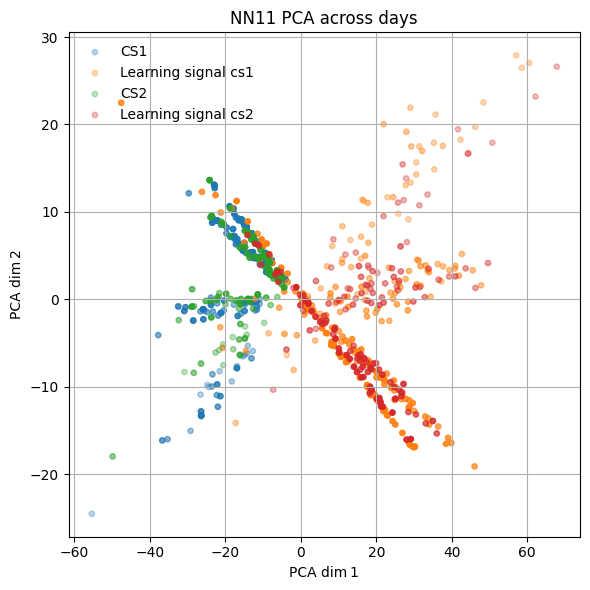

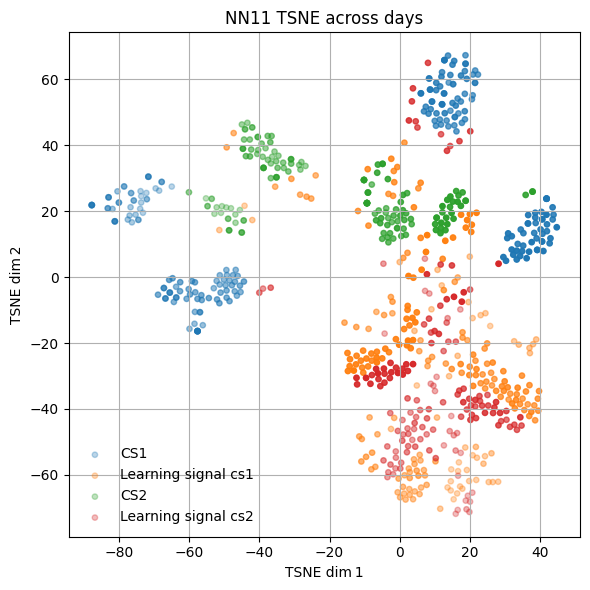

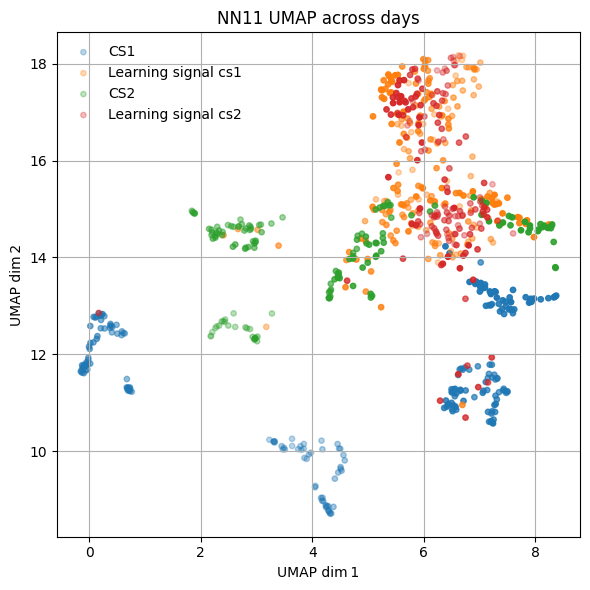

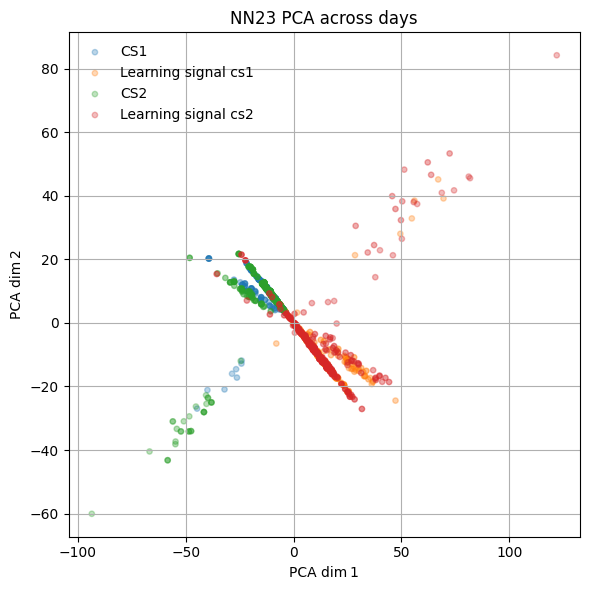

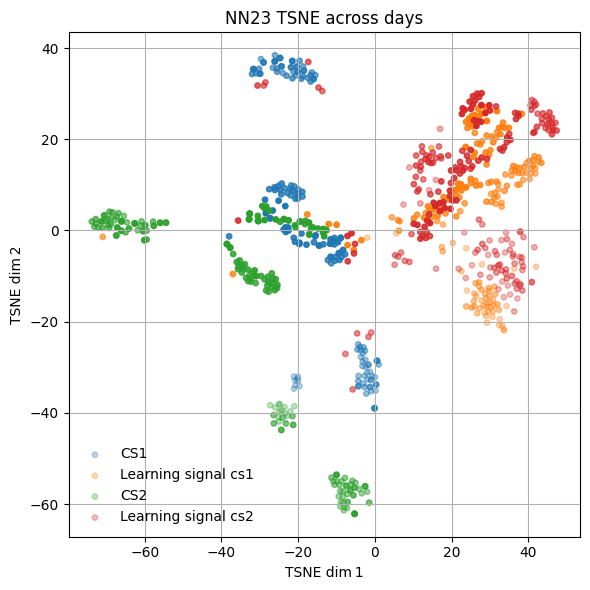

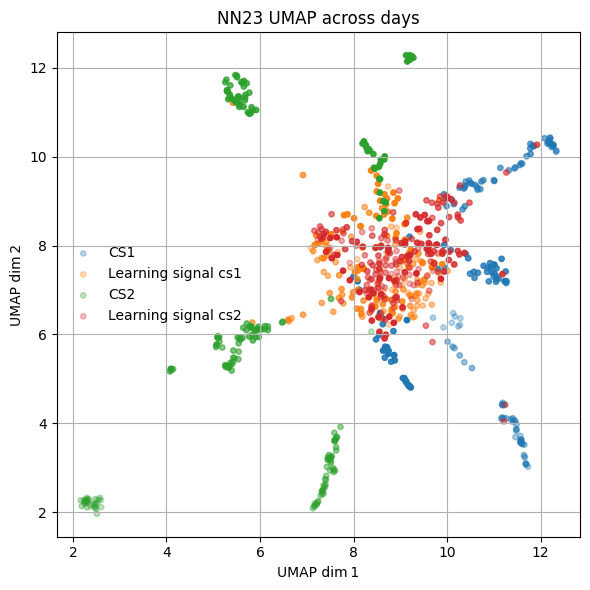

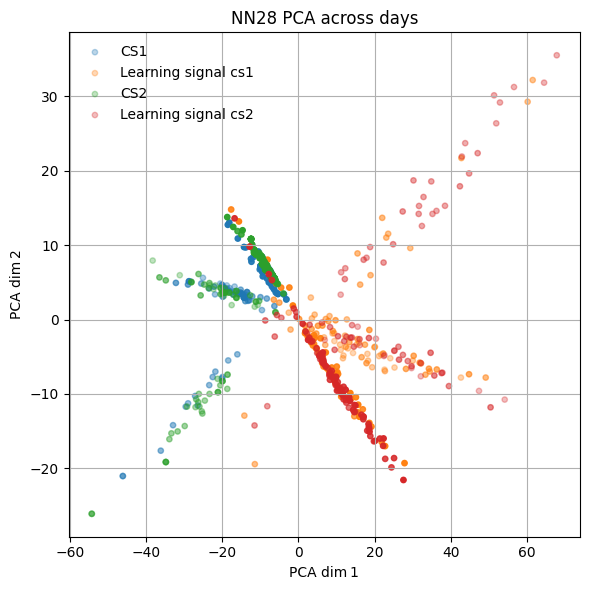

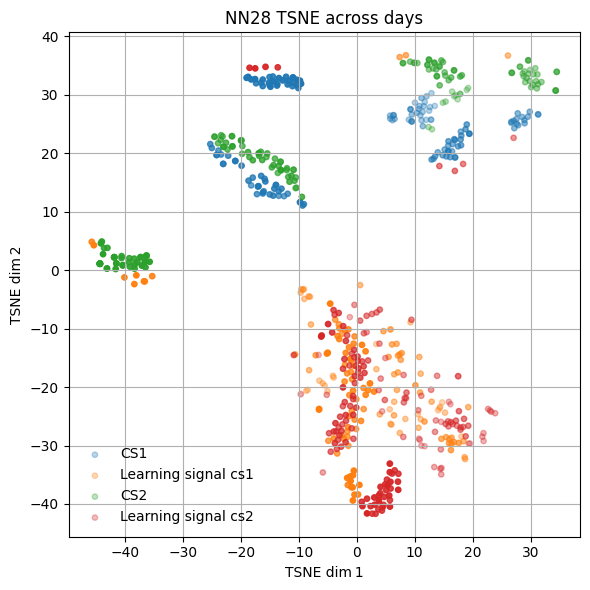

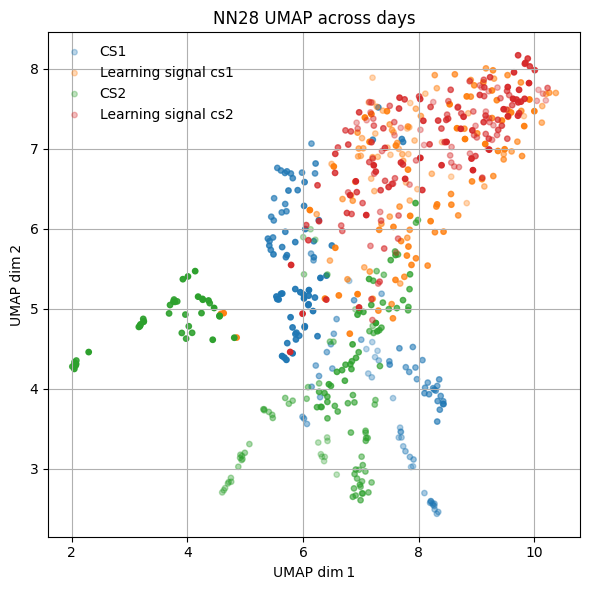

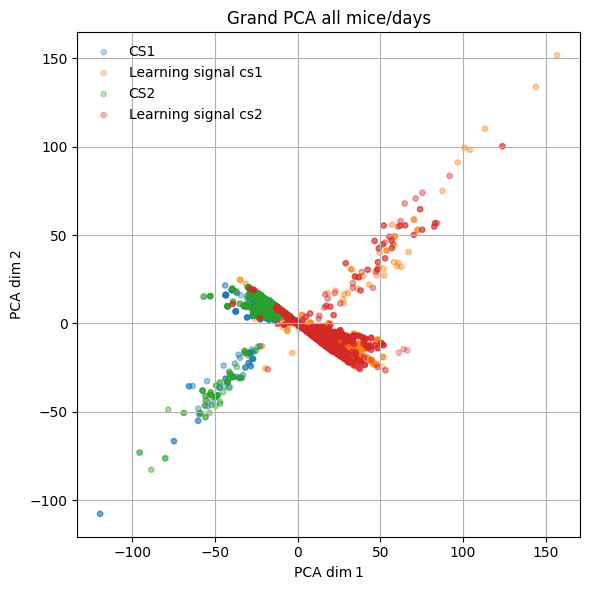

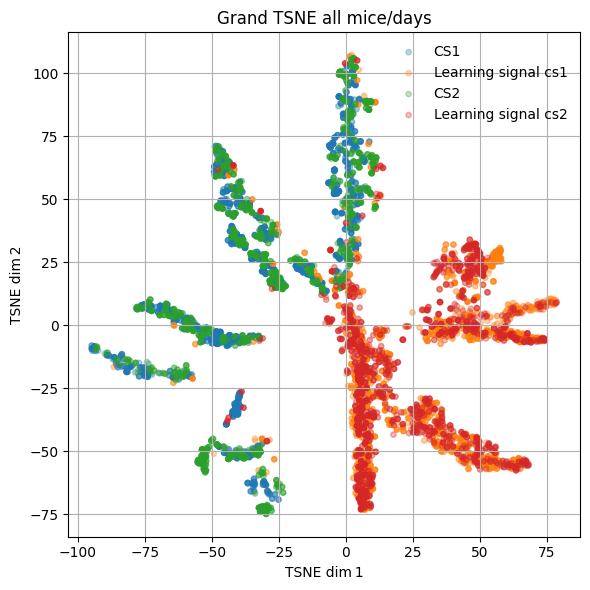

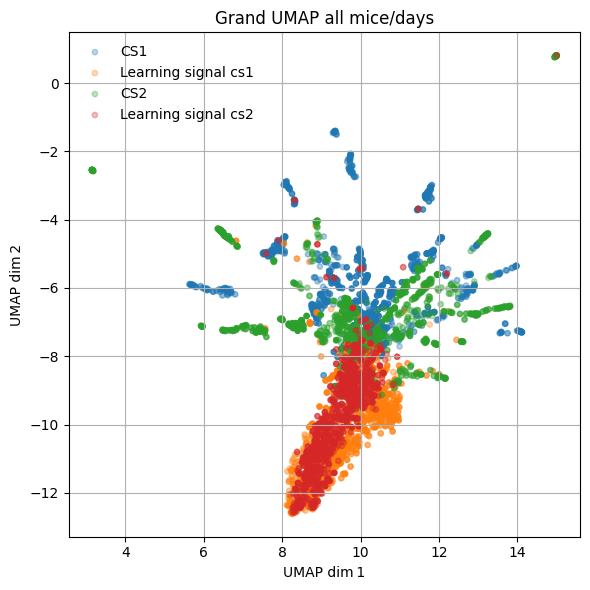

In [42]:

# — per-mouse across days —
for mouse, days in learning_signal.items():
    # determine max neurons across that mouse
    max_neur = max(o['mean_activity_cs_1'].shape[1] for o in days.values())

    # accumulate and pad each label
    cats_accum = {lbl: [] for lbl in ['CS1','Learning signal cs1','CS2','Learning signal cs2']}
    for out in days.values():
        for lbl, key in zip(cats_accum, 
                ['mean_activity_cs_1','mean_activity_r_1',
                 'mean_activity_cs_2','mean_activity_r_2']):
            arr = out[key]
            if arr.shape[1] < max_neur:
                pad = np.full((arr.shape[0], max_neur-arr.shape[1]), np.nan)
                arr = np.concatenate([arr, pad], axis=1)
            cats_accum[lbl].append(arr)

    # stack & plot
    cats_accum = {lbl: np.vstack(lst) for lbl, lst in cats_accum.items()}
    for method in ('pca','tsne','umap'):
        dim_red_plot(cats_accum,
                     title=f"{mouse} {method.upper()} across days",
                     method=method)

    results['per_mouse'][mouse] = cats_accum

# — grand across all mice & days —
# find max neurons over all
max_neur = max(
    out['mean_activity_cs_1'].shape[1]
    for days in learning_signal.values() for out in days.values()
)

cats_all = {lbl: [] for lbl in ['CS1','Learning signal cs1','CS2','Learning signal cs2']}
for days in learning_signal.values():
    for out in days.values():
        for lbl, key in zip(cats_all,
                ['mean_activity_cs_1','mean_activity_r_1',
                 'mean_activity_cs_2','mean_activity_r_2']):
            arr = out[key]
            if arr.shape[1] < max_neur:
                pad = np.full((arr.shape[0], max_neur-arr.shape[1]), np.nan)
                arr = np.concatenate([arr, pad], axis=1)
            cats_all[lbl].append(arr)

cats_all = {lbl: np.vstack(lst) for lbl, lst in cats_all.items()}
for method in ('pca','tsne','umap'):
    dim_red_plot(cats_all, title=f"Grand {method.upper()} all mice/days", method=method)

results['grand'] = cats_all


In [ ]:

results = {'per_mouse': {}, 'grand': {}}

# — per-mouse across days —
for mouse, days in day_outputs.items():
    # determine max neurons across that mouse
    max_neur = max(o['mean_activity_cs_1'].shape[1] for o in days.values())

    # accumulate and pad each label
    cats_accum = {lbl: [] for lbl in ['CS1','R1','CS2','R2']}
    for out in days.values():
        for lbl, key in zip(cats_accum, 
                ['mean_activity_cs_1','mean_activity_r_1',
                 'mean_activity_cs_2','mean_activity_r_2']):
            arr = out[key]
            if arr.shape[1] < max_neur:
                pad = np.full((arr.shape[0], max_neur-arr.shape[1]), np.nan)
                arr = np.concatenate([arr, pad], axis=1)
            cats_accum[lbl].append(arr)

    # stack & plot
    cats_accum = {lbl: np.vstack(lst) for lbl, lst in cats_accum.items()}
    for method in ('pca','tsne','umap'):
        dim_red_plot(cats_accum,
                     title=f"{mouse} {method.upper()} across days",
                     method=method)

    results['per_mouse'][mouse] = cats_accum

# — grand across all mice & days —
# find max neurons over all
max_neur = max(
    out['mean_activity_cs_1'].shape[1]
    for days in day_outputs.values() for out in days.values()
)

cats_all = {lbl: [] for lbl in ['CS1','R1','CS2','R2']}
for days in day_outputs.values():
    for out in days.values():
        for lbl, key in zip(cats_all,
                ['mean_activity_cs_1','mean_activity_r_1',
                 'mean_activity_cs_2','mean_activity_r_2']):
            arr = out[key]
            if arr.shape[1] < max_neur:
                pad = np.full((arr.shape[0], max_neur-arr.shape[1]), np.nan)
                arr = np.concatenate([arr, pad], axis=1)
            cats_all[lbl].append(arr)

cats_all = {lbl: np.vstack(lst) for lbl, lst in cats_all.items()}
for method in ('pca','tsne','umap'):
    dim_red_plot(cats_all, title=f"Grand {method.upper()} all mice/days", method=method)

results['grand'] = cats_all


# Cross-cond similarity plots

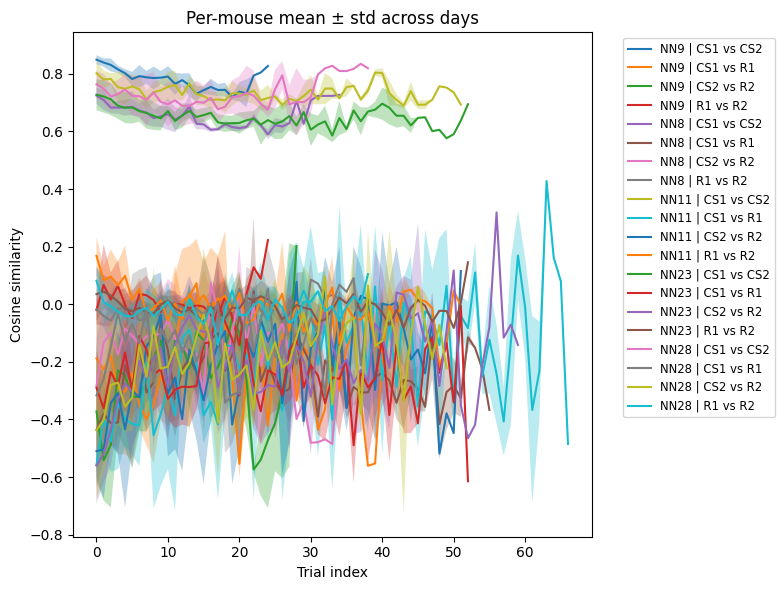

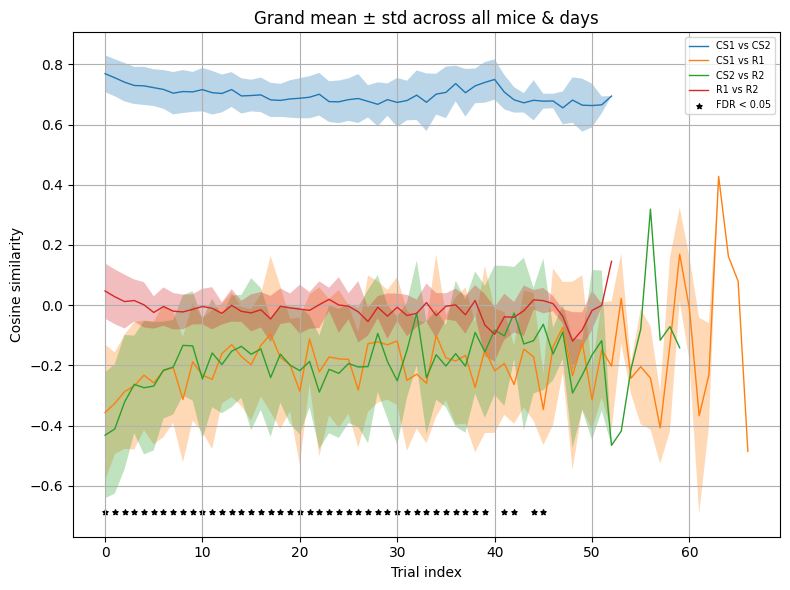

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import friedmanchisquare
from statsmodels.stats.multitest import multipletests

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def compute_cross_results(day_outputs, top_percent=None):
    labels = ["CS1 vs CS2","CS1 vs R1","CS2 vs R2", "R1 vs R2"]
    results = {mouse: {lab: [] for lab in labels}
               for mouse in day_outputs}

    for mouse, dates in day_outputs.items():
        for date, dr in sorted(dates.items()):
            cs1 = dr['mean_activity_cs_1']
            cs2 = dr['mean_activity_cs_2']
            r1  = dr['mean_activity_r_1']
            r2  = dr['mean_activity_r_2']

            def sims(m1, m2):
                n = min(m1.shape[0], m2.shape[0])
                out = []
                for t in range(n):
                    v1, v2 = m1[t], m2[t]
                    if top_percent is not None:
                        k = max(1, int(np.ceil(top_percent * len(v1))))
                        idx = np.intersect1d(
                            np.argsort(v1)[-k:],
                            np.argsort(v2)[-k:]
                        )
                        if idx.size == 0:
                            out.append(np.nan)
                            continue
                        v1, v2 = v1[idx], v2[idx]
                    out.append(cos_sim(v1, v2))
                return np.array(out)

            results[mouse]["CS1 vs CS2"].append(sims(cs1, cs2))
            results[mouse]["CS1 vs R1"].append(sims(cs1, r1))
            results[mouse]["CS2 vs R2"].append(sims(cs2, r2))
            results[mouse]["R1 vs R2"].append(sims(r1, r2))


    return results

def pad_and_stack(series_list):
    maxlen = max(s.shape[0] for s in series_list)
    out = np.full((len(series_list), maxlen), np.nan, dtype=float)
    for i, s in enumerate(series_list):
        out[i, : s.shape[0]] = s
    return out

def trialwise_friedman(results, alpha=0.05):
    labels = ["CS1 vs CS2","CS1 vs R1","CS2 vs R2", "R1 vs R2"]
    all_series = {lab: [] for lab in labels}
    for mouse_data in results.values():
        for lab in labels:
            all_series[lab].extend(mouse_data[lab])

    # Find global max length across all series
    global_max = max(s.shape[0]
                     for arr in all_series.values()
                     for s in arr)

    # Pad each label to (n_samples, global_max)
    data = {}
    for lab, series_list in all_series.items():
        arr = np.full((len(series_list), global_max), np.nan, dtype=float)
        for i, s in enumerate(series_list):
            arr[i, : s.shape[0]] = s
        data[lab] = arr

    # Friedman per trial index
    p_vals = np.full(global_max, np.nan)
    for i in range(global_max):
        cols = [data[lab][:, i] for lab in labels]
        mask = ~np.isnan(np.vstack(cols)).any(axis=0)
        if mask.sum() > 1:
            _, p_vals[i] = friedmanchisquare(*(col[mask] for col in cols))

    # BH‐correct
    valid = ~np.isnan(p_vals)
    rej, p_adj, _, _ = multipletests(p_vals[valid], alpha=alpha, method='fdr_bh')

    # build full‐length arrays
    p_adj_full = np.full_like(p_vals, np.nan)
    reject_full = np.zeros_like(p_vals, dtype=bool)
    p_adj_full[valid]   = p_adj
    reject_full[valid] = rej

    return p_vals, p_adj_full, reject_full

def plot_cross_category(results, p_bh, alpha=0.05):
    labels = ["CS1 vs CS2","CS1 vs R1","CS2 vs R2", "R1 vs R2"]

    # 1) Per-mouse mean ± std
    fig, ax = plt.subplots(figsize=(8,6))
    for mouse, by_label in results.items():
        for lab in labels:
            data = pad_and_stack(by_label[lab])
            mean_y = np.nanmean(data, axis=0)
            std_y  = np.nanstd( data, axis=0)
            x = np.arange(mean_y.shape[0])

            ax.plot(x, mean_y, label=f"{mouse} | {lab}")
            ax.fill_between(x,
                            mean_y - std_y,
                            mean_y + std_y,
                            alpha=0.3)

    ax.set_xlabel("Trial index")
    ax.set_ylabel("Cosine similarity")
    ax.set_title("Per-mouse mean ± std across days")
    ax.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

    # 2) Grand mean ± std, padded to length of p_bh
    L_global = len(p_bh)
    x = np.arange(L_global)

    fig, ax = plt.subplots(figsize=(8,6))
    for lab in labels:
        # gather all series for this lab
        all_series = []
        for by_label in results.values():
            all_series.extend(by_label[lab])

        # pad to L_global
        arr = np.full((len(all_series), L_global), np.nan, dtype=float)
        for i, s in enumerate(all_series):
            arr[i, : s.shape[0]] = s

        mean_y = np.nanmean(arr, axis=0)
        std_y  = np.nanstd( arr, axis=0)

        ax.plot(x, mean_y, label=lab, lw=1)
        ax.fill_between(x,
                        mean_y - std_y,
                        mean_y + std_y,
                        alpha=0.3)

    # overlay significance stars
    mask = p_bh < alpha
    y0, y1 = ax.get_ylim()
    y_star = y0 + 0.05 * (y1 - y0)
    ax.scatter(
        x[mask],
        np.full(mask.sum(), y_star),
        marker='*',
        color='k',
        s=15,
        label=f'FDR < {alpha}'
    )

    ax.set_xlabel("Trial index")
    ax.set_ylabel("Cosine similarity")
    ax.set_title("Grand mean ± std across all mice & days")
    ax.legend(fontsize='x-small')
    plt.tight_layout()
    plt.grid(True)
    plt.show()


results = compute_cross_results(learning_signal, top_percent=None)
p_raw, p_bh, sig = trialwise_friedman(results, alpha=0.05)
plot_cross_category(results, p_bh, alpha=0.05)


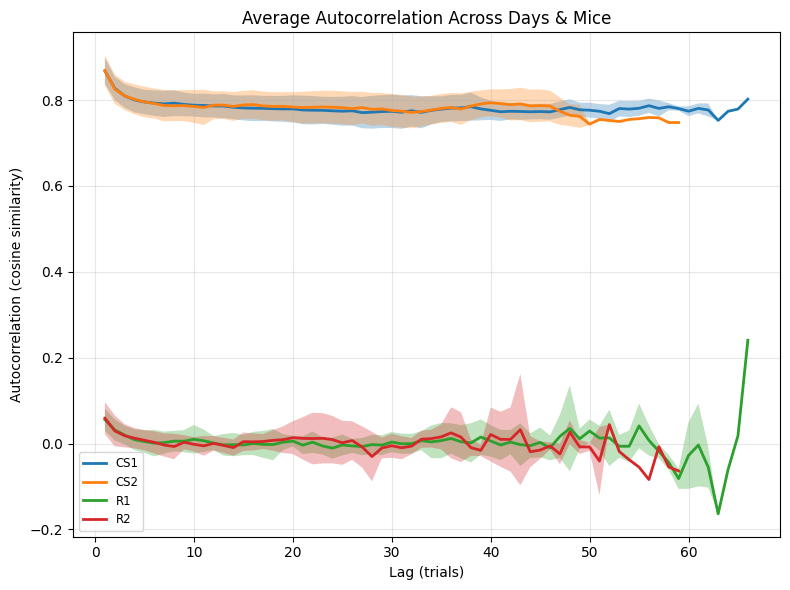

In [36]:
def compute_autocorr_results(day_outputs):
    """
    Compute trial-by-trial autocorrelation (cosine similarity) for each condition:
    CS1, CS2, R1, R2, across all mice and days.

    Returns a nested dict:
      results[mouse][condition_label] = list of 1D arrays (autocorrelation vs. lag) for each day.
    """
    condition_keys = {
        'mean_activity_cs_1': 'CS1',
        'mean_activity_cs_2': 'CS2',
        'mean_activity_r_1': 'R1',
        'mean_activity_r_2': 'R2'
    }
    results = {
        mouse: {label: [] for label in condition_keys.values()}
        for mouse in day_outputs
    }

    for mouse, dates in day_outputs.items():
        for date, dr in sorted(dates.items()):
            for key, label in condition_keys.items():
                activity = dr[key]  # shape: (n_trials, n_features)
                n_trials = activity.shape[0]
                if n_trials < 2:
                    continue
                autocorr = []
                for lag in range(1, n_trials):
                    sims = []
                    for t in range(n_trials - lag):
                        v1 = activity[t]
                        v2 = activity[t + lag]
                        sims.append(cos_sim(v1, v2))
                    autocorr.append(np.nanmean(sims) if sims else np.nan)
                results[mouse][label].append(np.array(autocorr))
    return results

def plot_autocorr(results):
    """
    Plot the average autocorrelation vs. lag for each condition (CS1, CS2, R1, R2),
    averaged across all mice and days, with ±1 std shading.
    """
    labels = ['CS1', 'CS2', 'R1', 'R2']
    # Gather all series for each label and compute global max lag
    aggregated = {label: [] for label in labels}
    global_max_lag = 0
    for mouse_data in results.values():
        for label in labels:
            for arr in mouse_data[label]:
                aggregated[label].append(arr)
                global_max_lag = max(global_max_lag, arr.shape[0])

    x = np.arange(1, global_max_lag + 1)

    plt.figure(figsize=(8, 6))
    for label in labels:
        series_list = aggregated[label]
        if not series_list:
            continue
        # Pad all series to global_max_lag
        arr = np.full((len(series_list), global_max_lag), np.nan, dtype=float)
        for i, s in enumerate(series_list):
            arr[i, :s.shape[0]] = s

        mean_vals = np.nanmean(arr, axis=0)
        std_vals = np.nanstd(arr, axis=0)

        plt.plot(x, mean_vals, label=label, lw=2)
        plt.fill_between(x,
                         mean_vals - std_vals,
                         mean_vals + std_vals,
                         alpha=0.3)

    plt.xlabel("Lag (trials)")
    plt.ylabel("Autocorrelation (cosine similarity)")
    plt.title("Average Autocorrelation Across Days & Mice")
    plt.legend(fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

autocorr_results = compute_autocorr_results(learning_signal)
plot_autocorr(autocorr_results)


  

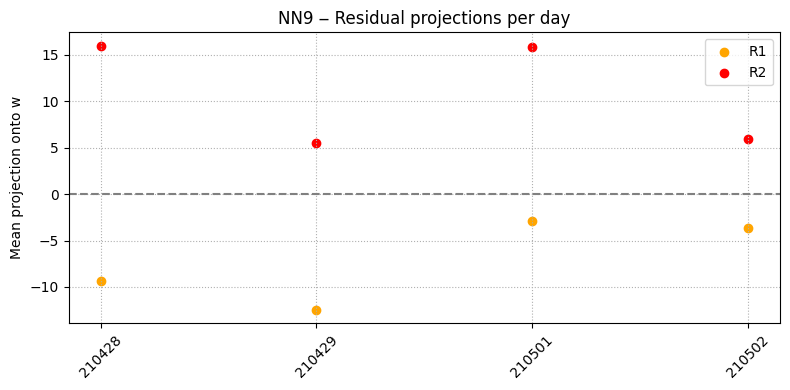

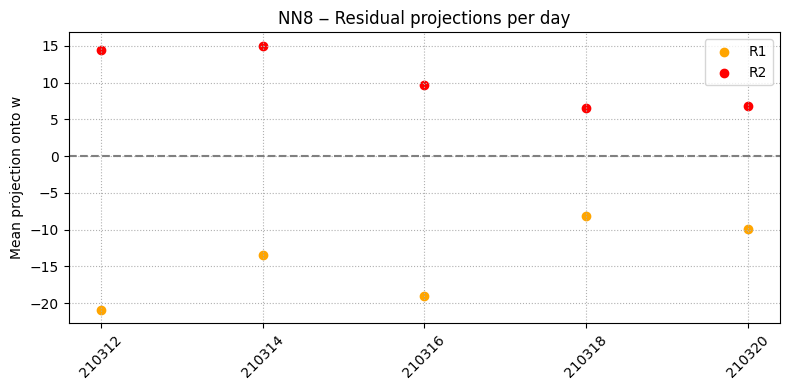

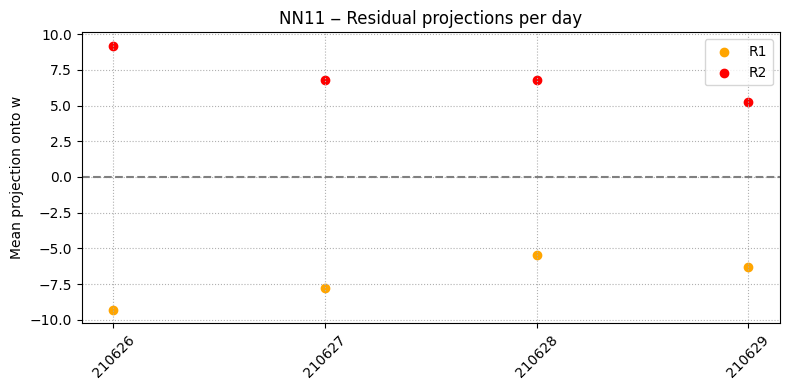

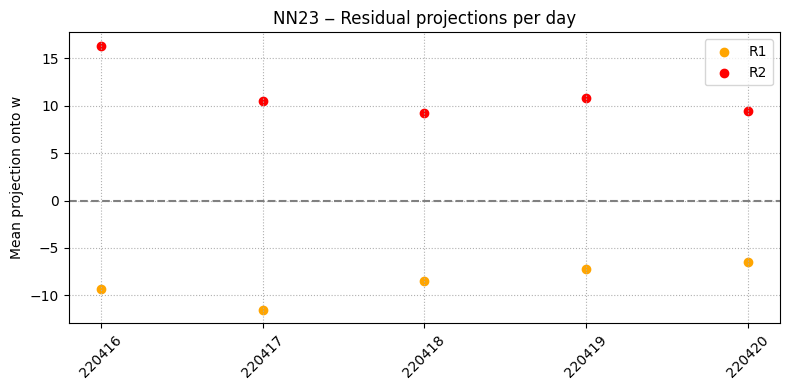

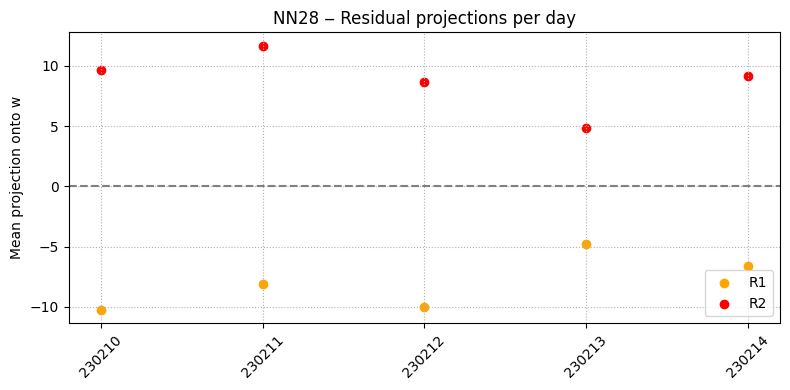

Per‐mouse aggregate mean projection (R1+R2, all days + all trials):
  NN9: 1.2215
  NN8: -3.9953
  NN11: -1.4731
  NN23: 2.0905
  NN28: 0.9262

Grand mean across all mice: -0.2461


In [44]:
per_mouse_day_means = {}

per_mouse_aggregate_means = {}
for mouse, days in learning_signal.items():
    # Sort the dates so that x‐axis ordering is consistent
    day_keys = sorted(days.keys())
    
    # Lists to collect day‐level means for R1 and R2
    r1_day_means = []
    r2_day_means = []
    
    # Create a figure for this mouse
    plt.figure(figsize=(8, 4))
    
    for day_index, date in enumerate(day_keys):
        info = days[date]
        
        cs1 = info['mean_activity_cs_1'] 
        cs2 = info['mean_activity_cs_2']  
        r1  = info['mean_activity_r_1']   
        r2  = info['mean_activity_r_2']   
        
        mu1 = cs1.mean(axis=0) 
        mu2 = cs2.mean(axis=0) 
        
        w = mu1 - mu2
        norm_w = np.linalg.norm(w)
        if norm_w != 0:
            w = w / norm_w  # now w is a unit vector in neuron‐space
        
        # (2‐C) Project every residual trial onto w
        proj_r1 = r1 @ w    # shape = (n_trials_r1,)
        proj_r2 = r2 @ w    # shape = (n_trials_r2,)
        
        mean_proj_r1 = proj_r1.mean()
        mean_proj_r2 = proj_r2.mean()
        r1_day_means.append(mean_proj_r1)
        r2_day_means.append(mean_proj_r2)
        
        plt.scatter(day_index, mean_proj_r1, color='orange', label='R1' if day_index == 0 else "")
        plt.scatter(day_index, mean_proj_r2, color='red',    label='R2' if day_index == 0 else "")
    
    plt.axhline(0, color='gray', linestyle='--')  # horizontal zero‐line
    plt.xticks(range(len(day_keys)), day_keys, rotation=45)
    plt.ylabel('Mean projection onto w')
    plt.title(f'{mouse} ‒ Residual projections per day')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()
    
    # Store the per‐day arrays in a dict
    per_mouse_day_means[mouse] = {
        'R1': np.array(r1_day_means),
        'R2': np.array(r2_day_means)
    }
    
    all_projections = []
    for date in day_keys:
        info = days[date]
        cs1 = info['mean_activity_cs_1']
        cs2 = info['mean_activity_cs_2']
        r1  = info['mean_activity_r_1']
        r2  = info['mean_activity_r_2']
        
        mu1 = cs1.mean(axis=0)
        mu2 = cs2.mean(axis=0)
        w = mu1 - mu2
        norm_w = np.linalg.norm(w)
        if norm_w != 0:
            w = w / norm_w
        
        proj_r1 = r1 @ w
        proj_r2 = r2 @ w
        all_projections.extend(proj_r1.tolist())
        all_projections.extend(proj_r2.tolist())
    
    # Convert to numpy array and take the overall mean
    all_projections = np.array(all_projections)
    per_mouse_aggregate_means[mouse] = np.mean(all_projections)

# ─────────────── (5) Print per‐mouse aggregate means ──────────────────────────
print("Per‐mouse aggregate mean projection (R1+R2, all days + all trials):")
for mouse, agg_mean in per_mouse_aggregate_means.items():
    print(f"  {mouse}: {agg_mean:.4f}")

# ─────────────── (6) Compute and print the grand mean across mice ─────────────
all_mouse_vals = np.array(list(per_mouse_aggregate_means.values()))
grand_mean = all_mouse_vals.mean()
print(f"\nGrand mean across all mice: {grand_mean:.4f}")

# decoding stim-identity with resids linear

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

learning_signal = {}

for mouse, day_dict in day_outputs.items():
    learning_signal[mouse] = {}

    for date, out in day_dict.items():
        m1 = out['mean_activity_cs_1']
        m2 = out['mean_activity_cs_2']
        r1 = out['mean_activity_r_1']
        r2 = out['mean_activity_r_2']
        trial_r1 = out['trial_r_1']
        trial_r2 = out['trial_r_2']
        r_any = out['mean_activity_r_any']

        r1_norm = r1 / np.mean(r_any, axis=0)
        r2_norm = r2 / np.mean(r_any, axis=0)

        reacts1 = m1[trial_r1]   
        reacts2 = m2[trial_r2] 
        stim_cs1 = r1_norm - reacts1
        stim_cs2 = r2_norm - reacts2

        print(reacts1.shape, stim_cs1.shape)
        print(reacts2.shape, stim_cs2.shape)
        print(date)

        learning_signal[mouse][date] = {
        'mean_activity_cs_1': reacts1,
        'stim_cs1': stim_cs1,
        'mean_activity_cs_2': reacts2,
        'stim_cs2': stim_cs2,
        'trial_r_1': trial_r1,
        'trial_r_2': trial_r2
        }

(18, 2713) (18, 2713)
(20, 2713) (20, 2713)
210428
(41, 2402) (41, 2402)
(22, 2402) (22, 2402)
210429
(25, 1770) (25, 1770)
(29, 1770) (29, 1770)
210501
(19, 1727) (19, 1727)
(28, 1727) (28, 1727)
210502
(14, 4134) (14, 4134)
(15, 4134) (15, 4134)
210312
(20, 3584) (20, 3584)
(9, 3584) (9, 3584)
210314
(17, 2434) (17, 2434)
(9, 2434) (9, 2434)
210316
(53, 1667) (53, 1667)
(35, 1667) (35, 1667)
210318
(56, 1292) (56, 1292)
(27, 1292) (27, 1292)
210320
(49, 2370) (49, 2370)
(26, 2370) (26, 2370)
210626
(63, 2128) (63, 2128)
(47, 2128) (47, 2128)
210627
(67, 1703) (67, 1703)
(52, 1703) (52, 1703)
210628
(49, 1303) (49, 1303)
(28, 1303) (28, 1303)
210629
(8, 3892) (8, 3892)
(29, 3892) (29, 3892)
220416
(45, 2682) (45, 2682)
(48, 2682) (48, 2682)
220417
(53, 1811) (53, 1811)
(60, 1811) (60, 1811)
220418
(35, 1676) (35, 1676)
(42, 1676) (42, 1676)
220419
(34, 1386) (34, 1386)
(38, 1386) (38, 1386)
220420
(32, 2152) (32, 2152)
(12, 2152) (12, 2152)
230210
(15, 2820) (15, 2820)
(32, 2820) (32,

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score

class TorchLinearClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 n_features=None,
                 lr=1e-3,
                 epochs=100,
                 batch_size=32,
                 weight_decay = .01,
                 random_state=42):
        
        self.n_features = n_features
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.weight_decay = weight_decay

        self.device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.classes_ = None

    def _build_model(self, n_features, n_classes):
        torch.manual_seed(self.random_state)
        model = nn.Linear(n_features, n_classes, bias=True)
        return model.to(self.device)

    def fit(self, X, y):
        """
        X: numpy array of shape (n_samples, n_features)
        y: numpy array of shape (n_samples,), labels must be 0 or 1
        """
        # Ensure reproducibility
        np.random.seed(self.random_state)
        torch.manual_seed(self.random_state)

        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.int64)
        n_samples, n_features = X.shape
        classes = np.unique(y)
        n_classes = len(classes)
        if n_classes != 2:
            raise ValueError("TorchLinearClassifier currently supports binary classification only (labels 0/1).")

        if self.n_features is None:
            self.n_features = n_features
        elif self.n_features != n_features:
            raise ValueError(f"n_features mismatch: expected {self.n_features}, got {n_features}")

        self.model = self._build_model(n_features, n_classes)
        self.classes_ = classes

        X_tensor = torch.from_numpy(X).to(self.device)
        y_tensor = torch.from_numpy(y).to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, 
                              weight_decay = self.weight_decay)

        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=min(self.batch_size, n_samples),
            shuffle=True
        )

        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                logits = self.model(batch_X)          # shape (batch_size, 2)
                loss = criterion(logits, batch_y)
                loss.backward()
                optimizer.step()

        return self

    def predict(self, X):
        """
        Return label predictions (0 or 1).
        """
        X = np.asarray(X, dtype=np.float32)
        X_tensor = torch.from_numpy(X).to(self.device)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(X_tensor)              # shape (n_samples, 2)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
        return preds

    def predict_proba(self, X):
        """
        Return class probabilities for each sample.
        """
        X = np.asarray(X, dtype=np.float32)
        X_tensor = torch.from_numpy(X).to(self.device)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(X_tensor)              # shape (n_samples, 2)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs

def within_day_decoding(learning_signal, cv_splits, random_state, lr, epochs, batch_size, weight_decay ):
    """
    For each mouse and each day in learning_signal, perform within‐day
    cross‐validated decoding (CS1 vs. CS2) of the residuals (R1 vs. R2)
    using a linear PyTorch classifier on GPU (if available).

    Returns a dict: within_day_scores[mouse][date] = balanced_accuracy
    """
    within_day_scores = {}
    outer_cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    for mouse, day_dict in learning_signal.items():
        within_day_scores[mouse] = {}
        for date, out in day_dict.items():
            R1 = out['mean_activity_r_1']    # shape = (n1, n_feat)
            R2 = out['mean_activity_r_2']    # shape = (n2, n_feat)
            n1, n_feat = R1.shape
            n2, _      = R2.shape

            if (n1 < cv_splits) or (n2 < cv_splits):
                within_day_scores[mouse][date] = np.nan
                continue

            X = np.vstack([R1, R2])                   
            y = np.array([0]*n1 + [1]*n2, dtype=int)   

            test_scores = []
            train_scores = []

            for train_idx, test_idx in outer_cv.split(X,y):
                X_train, y_train = X[train_idx], y[train_idx]
                X_test, y_test = X[test_idx], y[test_idx]

            
                clf = TorchLinearClassifier(
                    n_features=n_feat,
                    lr= lr,
                    epochs=epochs,
                    batch_size=batch_size,
                    weight_decay=weight_decay,
                    random_state=random_state
                )

                clf.fit(X_train, y_train)

                y_train_pred = clf.predict(X_train)
                y_test_pred = clf.predict(X_test)

                train_bal = balanced_accuracy_score(y_train, y_train_pred)
                test_bal = balanced_accuracy_score(y_test, y_test_pred)

                train_scores.append(train_bal)
                test_scores.append(test_bal)
        
            within_day_scores[mouse][date] = {
                'test_bal_acc': np.mean(test_scores),
                'train_bal_acc': np.mean(train_scores)
            }

    return within_day_scores

results = within_day_decoding(
    day_outputs,
    cv_splits=5,
    random_state=42,
    lr=1e-3,
    epochs=100,
    batch_size=32,
    weight_decay=.01
)
for mouse, day_res in results.items():
    print(f"--- Mouse {mouse} ---")
    for date, scores in day_res.items():
        print(f"  {date}: train_bal_acc = {scores['train_bal_acc']:.3f}, "
                f"test_bal_acc = {scores['test_bal_acc']:.3f}")

records = []
for mouse, day_res in results.items():
    for date, scores in day_res.items():
        records.append({
            'mouse':         mouse,
            'date':          date,
            'train_bal_acc': scores['train_bal_acc'],
            'test_bal_acc':  scores['test_bal_acc']
        })

for mouse, day_res in results.items():
    print(f"--- Mouse {mouse} ---")
    for date, scores in day_res.items():
        print(f"  {date}: train_bal_acc = {scores['train_bal_acc']:.3f}, "
                f"test_bal_acc = {scores['test_bal_acc']:.3f}")

df = pd.DataFrame(records)
df_valid = df.dropna(subset=['test_bal_acc']).copy()

mean_test_per_mouse = (
    df_valid.groupby('mouse')['test_bal_acc']
    .mean()
    .reset_index()
    .rename(columns={'test_bal_acc': 'mean_test_accuracy'})
)

# Compute grand mean test accuracy across all mice/days
grand_mean_test = df_valid['test_bal_acc'].mean()

print("\nPer‐mouse mean test accuracy across days:")
print(mean_test_per_mouse.to_string(index=False))
print(f"\nGrand mean test accuracy across all mice and days: {grand_mean_test:.3f}")


--- Mouse NN9 ---
  210428: train_bal_acc = 0.873, test_bal_acc = 0.717
  210429: train_bal_acc = 0.500, test_bal_acc = 0.500
  210501: train_bal_acc = 0.725, test_bal_acc = 0.573
  210502: train_bal_acc = 0.612, test_bal_acc = 0.500
--- Mouse NN8 ---
  210312: train_bal_acc = 0.687, test_bal_acc = 0.583
  210314: train_bal_acc = 0.555, test_bal_acc = 0.500
  210316: train_bal_acc = 0.745, test_bal_acc = 0.483
  210318: train_bal_acc = 0.614, test_bal_acc = 0.529
  210320: train_bal_acc = 0.500, test_bal_acc = 0.500
--- Mouse NN11 ---
  210626: train_bal_acc = 0.500, test_bal_acc = 0.500
  210627: train_bal_acc = 0.513, test_bal_acc = 0.500
  210628: train_bal_acc = 0.548, test_bal_acc = 0.540
  210629: train_bal_acc = 0.500, test_bal_acc = 0.500
--- Mouse NN23 ---
  220416: train_bal_acc = 0.500, test_bal_acc = 0.500
  220417: train_bal_acc = 0.597, test_bal_acc = 0.533
  220418: train_bal_acc = 0.653, test_bal_acc = 0.606
  220419: train_bal_acc = 0.643, test_bal_acc = 0.586
  220420

In [73]:
import numpy as np
import torch
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

def within_day_permutation_check(
    learning_signal,
    cv_splits=5,
    random_state=42,
    lr=1e-2,
    epochs=100,
    batch_size=32,
    weight_decay=1e-3,
    n_permutations=10
):
    """
    For each mouse/day, compute:
      1) test_bal_acc on the correct R1 vs. R2 labels
      2) mean test_bal_acc over n_permutations label shuffles

    Returns a dict:
      results[mouse][date] = {
        'true_test_bal_acc': float,
        'perm_test_bal_accs': List[float]   # length = n_permutations
      }
    """
    results = {}
    rng = np.random.RandomState(random_state)
    outer_cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    for mouse, day_dict in learning_signal.items():
        results[mouse] = {}
        for date, out in day_dict.items():
            R1 = out['stim_cs1'].astype(np.float32)
            R2 = out['stim_cs2'].astype(np.float32)
            n1, n_feat = R1.shape
            n2, _      = R2.shape

            # If too few trials in either class, skip
            if (n1 < cv_splits) or (n2 < cv_splits):
                results[mouse][date] = {
                    'true_test_bal_acc': np.nan,
                    'perm_test_bal_accs': [np.nan]*n_permutations
                }
                continue

            X = np.vstack([R1, R2])
            y = np.array([0]*n1 + [1]*n2, dtype=int)  # 0 = R1, 1 = R2

            # (1) Compute test_bal_acc on TRUE labels
            test_scores_true = []
            for train_idx, test_idx in outer_cv.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                X_test,  y_test  = X[test_idx],  y[test_idx]

                clf = TorchLinearClassifier(
                    n_features=n_feat,
                    lr=lr,
                    epochs=epochs,
                    batch_size=batch_size,
                    weight_decay=weight_decay,
                    random_state=random_state
                )
                clf.fit(X_train, y_train)
                y_test_pred = clf.predict(X_test)
                test_scores_true.append(balanced_accuracy_score(y_test, y_test_pred))

            true_test_bal_acc = float(np.mean(test_scores_true))

            # (2) Compute test_bal_acc on PERMUTED labels
            perm_test_bal_accs = []
            for perm_i in range(n_permutations):
                y_perm = y.copy()
                rng.shuffle(y_perm)    # in‐place shuffle

                test_scores_perm = []
                for train_idx, test_idx in outer_cv.split(X, y_perm):
                    X_train, y_train = X[train_idx], y_perm[train_idx]
                    X_test,  y_test  = X[test_idx],  y_perm[test_idx]

                    clf = TorchLinearClassifier(
                        n_features=n_feat,
                        lr=lr,
                        epochs=epochs,
                        batch_size=batch_size,
                        weight_decay=weight_decay,
                        random_state=random_state + perm_i  # slightly different seed per perm
                    )
                    clf.fit(X_train, y_train)
                    y_test_pred = clf.predict(X_test)
                    test_scores_perm.append(balanced_accuracy_score(y_test, y_test_pred))

                perm_test_bal_accs.append(float(np.mean(test_scores_perm)))

            results[mouse][date] = {
                'true_test_bal_acc': true_test_bal_acc,
                'perm_test_bal_accs': perm_test_bal_accs
            }

    return results



perm_results = within_day_permutation_check(
    learning_signal,
    cv_splits=5,
    random_state=42,
    lr=1e-2,
    epochs=1,
    batch_size=32,
    weight_decay=1e-3,
    n_permutations=20
)


for mouse, day_dict in perm_results.items():
    print(f"=== Mouse {mouse} ===")
    for date, scores in day_dict.items():
        if np.isnan(scores['true_test_bal_acc']):
            print(f"  {date}: too few trials (skipped)")
            continue
        mean_perm = np.mean(scores['perm_test_bal_accs'])
        std_perm  = np.std(scores['perm_test_bal_accs'], ddof=1)
        print(
            f"  {date}:\n"
            f"    True test_bal_acc = {scores['true_test_bal_acc']:.3f}\n"
            f"    Perm  test_bal_acc = {mean_perm:.3f} ± {std_perm:.3f}  (n={len(scores['perm_test_bal_accs'])})"
        )


=== Mouse NN9 ===
  210428:
    True test_bal_acc = 0.817
    Perm  test_bal_acc = 0.536 ± 0.101  (n=20)
  210429:
    True test_bal_acc = 0.686
    Perm  test_bal_acc = 0.496 ± 0.073  (n=20)
  210501:
    True test_bal_acc = 0.653
    Perm  test_bal_acc = 0.525 ± 0.069  (n=20)
  210502:
    True test_bal_acc = 0.678
    Perm  test_bal_acc = 0.496 ± 0.059  (n=20)
=== Mouse NN8 ===
  210312:
    True test_bal_acc = 0.900
    Perm  test_bal_acc = 0.497 ± 0.101  (n=20)
  210314:
    True test_bal_acc = 0.650
    Perm  test_bal_acc = 0.489 ± 0.096  (n=20)
  210316:
    True test_bal_acc = 0.750
    Perm  test_bal_acc = 0.500 ± 0.114  (n=20)
  210318:
    True test_bal_acc = 0.726
    Perm  test_bal_acc = 0.481 ± 0.072  (n=20)
  210320:
    True test_bal_acc = 0.843
    Perm  test_bal_acc = 0.496 ± 0.062  (n=20)
=== Mouse NN11 ===
  210626:
    True test_bal_acc = 0.889
    Perm  test_bal_acc = 0.511 ± 0.079  (n=20)
  210627:
    True test_bal_acc = 0.876
    Perm  test_bal_acc = 0.485 ± 0.

In [94]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

def classify_on_pcs(R1, R2, n_pcs=20, cv_splits=5, random_state=0):
    """
    Project R1/R2 down to n_pcs via PCA, then do a 5‐fold CV logistic regression.
    Returns the balanced‐accuracy.
    """
    X = np.vstack([R1, R2])      # shape = (n1+n2, n_neurons)
    y = np.array([0]*len(R1) + [1]*len(R2))

    # If there are fewer samples than n_pcs, reduce n_pcs
    n_samples, _ = X.shape
    n_pcs = min(n_pcs, n_samples-1)

    pca = PCA(n_components=n_pcs, random_state=random_state)
    X_pcs = pca.fit_transform(X)

    clf = LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=1000,
        random_state=random_state
    )
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    scores = cross_val_score(clf, X_pcs, y, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
    return scores.mean()

results_pca = {}
for mouse, days in learning_signal.items():
    results_pca[mouse] = {}
    for date, out in days.items():
        R1 = out['stim_cs1'].astype(np.float32)
        R2 = out['stim_cs2'].astype(np.float32)
        if (len(R1) < 5) or (len(R2) < 5):
            results_pca[mouse][date] = np.nan
            continue

        # Try a sequence of dimensions and report them
        acc_5pc  = classify_on_pcs(R1, R2, n_pcs=5,  cv_splits=5, random_state=42)
        acc_20pc = classify_on_pcs(R1, R2, n_pcs=20, cv_splits=5, random_state=42)
        acc_50pc = classify_on_pcs(R1, R2, n_pcs=50, cv_splits=5, random_state=42)

        results_pca[mouse][date] = {
            '5PCs':  float(acc_5pc),
            '20PCs': float(acc_20pc),
            '50PCs': float(acc_50pc)
        }

# Print out
for mouse, days in results_pca.items():
    print(f"=== Mouse {mouse} ===")
    for date, accs in days.items():
        if np.isnan(accs['5PCs']):
            print(f"  {date}: too few trials (skipped)")
        else:
            print(f"  {date}: 5PCs={accs['5PCs']:.3f}, 20PCs={accs['20PCs']:.3f}, 50PCs={accs['50PCs']:.3f}")


=== Mouse NN9 ===
  210428: 5PCs=0.792, 20PCs=0.833, 50PCs=0.867
  210429: 5PCs=0.769, 20PCs=0.844, 50PCs=0.855
  210501: 5PCs=0.663, 20PCs=0.800, 50PCs=0.860
  210502: 5PCs=0.590, 20PCs=0.705, 50PCs=0.550
=== Mouse NN8 ===
  210312: 5PCs=1.000, 20PCs=0.967, 50PCs=1.000
  210314: 5PCs=0.900, 20PCs=0.650, 50PCs=0.500
  210316: 5PCs=0.758, 20PCs=0.650, 50PCs=0.550
  210318: 5PCs=0.930, 20PCs=0.971, 50PCs=0.924
  210320: 5PCs=0.948, 20PCs=0.954, 50PCs=0.913
=== Mouse NN11 ===
  210626: 5PCs=0.970, 20PCs=0.970, 50PCs=0.950
  210627: 5PCs=0.947, 20PCs=0.981, 50PCs=0.919
  210628: 5PCs=0.831, 20PCs=0.939, 50PCs=0.931
  210629: 5PCs=0.769, 20PCs=0.950, 50PCs=0.963
=== Mouse NN23 ===
  220416: 5PCs=0.710, 20PCs=0.983, 50PCs=0.500
  220417: 5PCs=0.969, 20PCs=0.990, 50PCs=1.000
  220418: 5PCs=0.958, 20PCs=0.965, 50PCs=0.938
  220419: 5PCs=0.978, 20PCs=1.000, 50PCs=1.000
  220420: 5PCs=0.885, 20PCs=0.897, 50PCs=0.915
=== Mouse NN28 ===
  230210: 5PCs=0.838, 20PCs=0.821, 50PCs=0.633
  230211: 5PCs

In [ ]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

def classify_with_subset(R1, R2, k, cv_splits=5, repeats=10, random_state=0):
    """
    Repeatedly (repeats times) pick k random features out of R1/R2,
    do 5‐fold CV logistic‐regression, return mean ± std balanced‐acc.
    """
    n1, n_feat = R1.shape
    n2, _      = R2.shape
    X_full = np.vstack([R1, R2])
    y_full = np.array([0]*n1 + [1]*n2)

    rng = np.random.RandomState(random_state)
    accs = []
    for rep in range(repeats):
        cols = rng.choice(n_feat, size=k, replace=False)
        X_sub = X_full[:, cols]

        clf = LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='lbfgs',
            max_iter=1000,
            random_state=random_state + rep
        )
        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state+rep)
        scores = cross_val_score(clf, X_sub, y_full, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
        accs.append(scores.mean())

    return np.mean(accs), np.std(accs)


k_list = [1, 5, 10, 25, 50, 100, 200, 500, 1000]
results_subsample = {}

for mouse, days in day_outputs.items():
    results_subsample[mouse] = {}
    for date, out in days.items():
        R1 = out['mean_activity_r_1'].astype(np.float32)
        R2 = out['mean_activity_r_2'].astype(np.float32)
        n1, n_feat = R1.shape
        n2, _      = R2.shape
        if (n1 < 5) or (n2 < 5):
            results_subsample[mouse][date] = {k: (np.nan, np.nan) for k in k_list}
            continue

        day_res = {}
        for k in k_list:
            if k > n_feat:
                day_res[k] = (np.nan, np.nan)
            else:
                mu, sigma = classify_with_subset(R1, R2, k, cv_splits=5, repeats=5, random_state=42)
                day_res[k] = (mu, sigma)
        results_subsample[mouse][date] = day_res

records = []
for mouse, days in results_subsample.items():
    for date, subs in days.items():
        for k, (mu, sigma) in subs.items():
            records.append({
                'mouse': mouse,
                'date': date,
                'k': k,
                'mu': mu
            })

df = pd.DataFrame(records)

mean_per_mouse_k = (
    df
    .groupby(['mouse', 'k'])['mu']
    .mean()
    .reset_index()
    .sort_values(['mouse', 'k'])
)

mean_per_k = (
    df
    .groupby('k')['mu']
    .mean()
    .reset_index()
    .sort_values('k')
)

for mouse in mean_per_mouse_k['mouse'].unique():
    print(f"=== Mouse {mouse} ===")
    subset = mean_per_mouse_k[mean_per_mouse_k['mouse'] == mouse]
    for _, row in subset.iterrows():
        print(f"  {row['k']:>4} neurons → mean accuracy = {row['mu']:.3f}")
    print()  # blank line between mice

print("=== Grand means across all mice & days ===")
for _, row in mean_per_k.iterrows():
    print(f"  {row['k']:>4} neurons → grand mean accuracy = {row['mu']:.3f}")



=== Mouse NN11 ===
     1 neurons → mean accuracy = 0.500
     5 neurons → mean accuracy = 0.500
    10 neurons → mean accuracy = 0.511
    25 neurons → mean accuracy = 0.523
    50 neurons → mean accuracy = 0.542
   100 neurons → mean accuracy = 0.563
   200 neurons → mean accuracy = 0.629
   500 neurons → mean accuracy = 0.708
  1000 neurons → mean accuracy = 0.755

=== Mouse NN23 ===
     1 neurons → mean accuracy = 0.500
     5 neurons → mean accuracy = 0.501
    10 neurons → mean accuracy = 0.544
    25 neurons → mean accuracy = 0.598
    50 neurons → mean accuracy = 0.674
   100 neurons → mean accuracy = 0.747
   200 neurons → mean accuracy = 0.803
   500 neurons → mean accuracy = 0.846
  1000 neurons → mean accuracy = 0.859

=== Mouse NN28 ===
     1 neurons → mean accuracy = 0.499
     5 neurons → mean accuracy = 0.497
    10 neurons → mean accuracy = 0.509
    25 neurons → mean accuracy = 0.510
    50 neurons → mean accuracy = 0.529
   100 neurons → mean accuracy = 0.569
   20

# decoding stim-identity with resids non-linear

In [6]:
from xgboost import XGBClassifier, cv, DMatrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold

def compute_global_max_neurons(learning_signal):
    """
    Scans all mice and days to find the maximum neuron count (number of columns)
    among all 'stim_cs1' and 'stim_cs2' arrays.
    """
    global_max = 0
    for mouse, day_dict in learning_signal.items():
        for out in day_dict.values():
            for key in ('mean_activity_r_1', 'mean_activity_r_2'):
                arr = out[key]
                if arr.ndim == 2:
                    global_max = max(global_max, arr.shape[1])
    return global_max

def gather_R1_R2_for_mouse(learning_signal, mouse, pad_to=None):
    """
    Collects R1 vs. R2 residuals for one mouse, padding with NaNs to 'pad_to' features.
    If pad_to is None, it uses the local max neurons for that mouse.
    Returns:
      X : (n_trials, pad_to) array of residuals
      y : (n_trials,) labels (0=R1, 1=R2)
    """
    # Determine pad length
    if pad_to is None:
        # local max
        max_neur = 0
        for date, out in learning_signal[mouse].items():
            for key in ('mean_activity_r_1', 'mean_activity_r_2'):
                arr = out[key]
                if arr.ndim == 2:
                    max_neur = max(max_neur, arr.shape[1])
    else:
        max_neur = pad_to

    X_list, y_list, days_list = [], [], []
    for date, out in learning_signal[mouse].items():
        arr1 = out['mean_activity_r_1']
        n_trials1, n_neur1 = arr1.shape
        if n_neur1 < max_neur:
            pad1 = np.full((n_trials1, max_neur - n_neur1), np.nan, dtype=float)
            arr1_padded = np.concatenate([arr1, pad1], axis=1)
        else:
            arr1_padded = arr1.astype(float)
        X_list.append(arr1_padded)
        y_list.extend([0] * n_trials1)
        days_list.extend([date] * n_trials1)

        arr2 = out['mean_activity_r_2']
        n_trials2, n_neur2 = arr2.shape
        if n_neur2 < max_neur:
            pad2 = np.full((n_trials2, max_neur - n_neur2), np.nan, dtype=float)
            arr2_padded = np.concatenate([arr2, pad2], axis=1)
        else:
            arr2_padded = arr2.astype(float)
        X_list.append(arr2_padded)
        y_list.extend([1] * n_trials2)
        days_list.extend([date] * n_trials2)

    if not X_list:
        return np.empty((0, max_neur)), np.array([], dtype=int)

    X = np.vstack(X_list)
    y = np.array(y_list, dtype=int)
    days = np.array(days_list)
    return X, y, days

def within_mouse_decoding(X, y, days, random_state=0):
    """
    5‐fold cross‐validation for binary R1 vs. R2 using XGBoost (GPU).
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=int)
    days = np.asarray(days)
    
    unique_days = np.unique(days)
    if unique_days.shape[0] < 2:
        print('what')
        return [], None
    
    accuracies = []
    
    for d in unique_days:
        train_mask = (days != d)
        test_mask  = (days == d)
        
        if not np.any(test_mask):
            continue
        
        X_train = X[train_mask]
        y_train = y[train_mask]
        X_test  = X[test_mask]
        y_test  = y[test_mask]
        
        unique_train, counts_train = np.unique(y_train, return_counts=True)
        train_counts = dict(zip(unique_train, counts_train))
        if train_counts.get(0, 0) < 1 or train_counts.get(1, 0) < 1:
            continue
        
        unique_test, counts_test = np.unique(y_test, return_counts=True)
        test_counts = dict(zip(unique_test, counts_test))
        if test_counts.get(0, 0) < 1 or test_counts.get(1, 0) < 1:
            continue
        
        scaler = StandardScaler().fit(X_train)
        X_train_z = scaler.transform(X_train)
        X_test_z  = scaler.transform(X_test)
        
        clf = XGBClassifier(
            tree_method='gpu_hist',
            predictor='gpu_predictor',
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=random_state
        )
        clf.fit(X_train_z, y_train)
        acc = clf.score(X_test_z, y_test)
        accuracies.append(acc)
    
    if len(accuracies) == 0:
        return [], None
    else:
        return accuracies, float(np.mean(accuracies))


def leave_one_mouse_out_decoding(learning_signal, pad_to, random_state=0):
    """
    Leave-one-mouse-out R1 vs R2 decoding, padding all mice to 'pad_to' features.
    """
    mice = list(learning_signal.keys())
    results = {}
    for held_out in mice:
        X_train_list, y_train_list = [], []
        X_test, y_test, days_mouse = gather_R1_R2_for_mouse(learning_signal, held_out, pad_to=pad_to)

        if X_test.shape[0] < 1 or len(np.unique(y_test)) < 2:
            results[held_out] = None
            continue

        for mouse in mice:
            if mouse == held_out:
                continue
            Xm, ym, days_mouse = gather_R1_R2_for_mouse(learning_signal, mouse, pad_to=pad_to)
            X_train_list.append(Xm)
            y_train_list.append(ym)

        X_train = np.vstack(X_train_list)
        y_train = np.concatenate(y_train_list)
        if len(np.unique(y_train)) < 2:
            results[held_out] = None
            continue

        scaler = StandardScaler().fit(X_train)
        X_train_z = scaler.transform(X_train)
        X_test_z  = scaler.transform(X_test)

        clf = XGBClassifier(
            tree_method='gpu_hist',
            predictor='gpu_predictor',
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=random_state
        )
        clf.fit(X_train_z, y_train)
        acc = clf.score(X_test_z, y_test)
        results[held_out] = acc

    return results

def gather_X_y_day(learning_signal, mouse, pad_to=None):
    """
    Collects R1+R2 residuals and day-index labels for one mouse, padding to 'pad_to' or local max.
    """
    dates = sorted(learning_signal[mouse].keys(), key=lambda s: pd.to_datetime(s))
    day_to_idx = {date: i for i, date in enumerate(dates, start=1)}

    if pad_to is None:
        max_neur = 0
        for date in dates:
            out = learning_signal[mouse][date]
            for key in ('mean_activity_r_1', 'mean_activity_r_2'):
                arr = out[key]
                if arr.ndim == 2:
                    max_neur = max(max_neur, arr.shape[1])
    else:
        max_neur = pad_to

    X_list, yday_list, day_list = [], [], []
    for date in dates:
        out = learning_signal[mouse][date]
        day_idx = day_to_idx[date]

        for key in ('mean_activity_r_1', 'mean_activity_r_2'):
            arr = out[key]
            n_trials, n_neur = arr.shape
            if n_neur < max_neur:
                pad = np.full((n_trials, max_neur - n_neur), np.nan, dtype=float)
                arr = np.concatenate([arr, pad], axis=1)
            else:
                arr = arr.astype(float)

            X_list.append(arr)
            yday_list.extend([day_idx] * n_trials)
            day_list.extend([date] * n_trials)
            
    days = np.array(day_list)
    if not X_list:
        return None, None

    X = np.vstack(X_list)
    yday = np.array(yday_list, dtype=int)
    return X, yday, days


global_max = compute_global_max_neurons(day_outputs)

print("=== Within‐Mouse R1 vs. R2 cross‐validation ===")
within_mouse_scores = {}
for mouse in day_outputs.keys():
    Xm, ym, days_mouse = gather_R1_R2_for_mouse(day_outputs, mouse, pad_to=global_max)
    accuracies, mean_acc = within_mouse_decoding(Xm, ym, days_mouse, random_state=42)
    if not accuracies:
        print(f"{mouse}: Too few R1/R2 trials for 5‐fold CV.")
        within_mouse_scores[mouse] = None
    else:
        acc_arr = np.array(accuracies)
        print(f"{mouse}: 5‐fold CV accuracies = {np.round(acc_arr, 3).tolist()} (mean={mean_acc:.3f})")
        within_mouse_scores[mouse] = mean_acc

print("\n=== Leave‐One‐Mouse‐Out R1 vs. R2 ===")
leave_one_mouse_scores = leave_one_mouse_out_decoding(day_outputs, pad_to=global_max, random_state=42)
for mouse, acc in leave_one_mouse_scores.items():
    if acc is None:
        print(f"{mouse}: Insufficient data for leave‐one‐mouse‐out.")
    else:
        print(f"{mouse} held‐out: test accuracy = {acc:.3f}")



=== Within‐Mouse R1 vs. R2 cross‐validation ===
NN9: 5‐fold CV accuracies = [0.526, 0.365, 0.407, 0.532] (mean=0.458)
NN8: 5‐fold CV accuracies = [0.414, 0.483, 0.385, 0.511, 0.494] (mean=0.457)
NN11: 5‐fold CV accuracies = [0.547, 0.627, 0.597, 0.584] (mean=0.589)
NN23: 5‐fold CV accuracies = [0.514, 0.559, 0.681, 0.636, 0.625] (mean=0.603)
NN28: 5‐fold CV accuracies = [0.5, 0.404, 0.421, 0.416, 0.44] (mean=0.436)

=== Leave‐One‐Mouse‐Out R1 vs. R2 ===
NN9 held‐out: test accuracy = 0.396
NN8 held‐out: test accuracy = 0.427
NN11 held‐out: test accuracy = 0.423
NN23 held‐out: test accuracy = 0.492
NN28 held‐out: test accuracy = 0.436


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

def within_day_decoding(learning_signal,
                                cv_splits=5,
                                random_state=42):
   
    within_day_scores = {}
    outer_cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    for mouse, day_dict in learning_signal.items():
        within_day_scores[mouse] = {}
        for date, out in day_dict.items():
            R1 = out['mean_activity_r_1']   # shape = (n1, n_feat)
            R2 = out['mean_activity_r_2']   # shape = (n2, n_feat)
            n1, n_feat = R1.shape
            n2, _      = R2.shape

            if (n1 < cv_splits) or (n2 < cv_splits):
                within_day_scores[mouse][date] = np.nan
                continue

            X = np.vstack([R1, R2])
            y = np.array([0]*n1 + [1]*n2, dtype=int)
            total_samples = n1 + n2

            pipe = Pipeline([
                ("clf", XGBClassifier(
                    use_label_encoder=False,
                    eval_metric="logloss",
                    random_state=random_state,
                    tree_method="gpu_hist",  
                    max_depth=7,             
                    n_estimators=50,         
                    learning_rate=0.01,      
                    reg_lambda=1,            
                ))
            ])

            scores = cross_val_score(
                pipe, X, y,
                cv=outer_cv,
                scoring="balanced_accuracy",
                n_jobs=-1
            )
            within_day_scores[mouse][date] = float(np.mean(scores))

    return within_day_scores

scores_by_day = within_day_decoding(day_outputs, cv_splits=5, random_state=42)

for mouse, day_scores in scores_by_day.items():
    print(f"--- Mouse {mouse} ---")
    for date, acc in day_scores.items():
        if not acc:
            print(f"  {date}: too few trials for {5}-fold CV (skipped)")
        else:
            print(f"  {date}: within-day CV accuracy = {acc:.3f}")

records = []
for mouse, day_scores in scores_by_day.items():
    for date, acc in day_scores.items():
        records.append({'mouse': mouse, 'date': date, 'accuracy': acc})

df = pd.DataFrame(records)

# Drop days where accuracy is None (couldn't compute)
df_valid = df.dropna(subset=['accuracy']).copy()
df_valid['accuracy'] = df_valid['accuracy'].astype(float)

# Compute mean per mouse across days
mean_per_mouse = df_valid.groupby('mouse')['accuracy'].mean().reset_index()
mean_per_mouse.columns = ['mouse', 'mean_accuracy_across_days']

# Compute grand mean across all mice and days
grand_mean = df_valid['accuracy'].mean()

print(mean_per_mouse)

print(f"Grand mean accuracy across all mice and days: {grand_mean:.3f}")

/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:13:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:13:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:13:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:13

--- Mouse NN9 ---
  210428: within-day CV accuracy = 0.483
  210429: within-day CV accuracy = 0.620
  210501: within-day CV accuracy = 0.650
  210502: within-day CV accuracy = 0.797
--- Mouse NN8 ---
  210312: within-day CV accuracy = 0.617
  210314: within-day CV accuracy = 0.500
  210316: within-day CV accuracy = 0.567
  210318: within-day CV accuracy = 0.768
  210320: within-day CV accuracy = 0.612
--- Mouse NN11 ---
  210626: within-day CV accuracy = 0.587
  210627: within-day CV accuracy = 0.612
  210628: within-day CV accuracy = 0.717
  210629: within-day CV accuracy = 0.652
--- Mouse NN23 ---
  220416: within-day CV accuracy = 0.500
  220417: within-day CV accuracy = 0.827
  220418: within-day CV accuracy = 0.873
  220419: within-day CV accuracy = 0.823
  220420: within-day CV accuracy = 0.839
--- Mouse NN28 ---
  230210: within-day CV accuracy = 0.486
  230211: within-day CV accuracy = 0.486
  230212: within-day CV accuracy = 0.807
  230213: within-day CV accuracy = 0.586
  230

/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:14:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:14:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:14:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:02:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:02:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:02:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/lbeumer/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:02

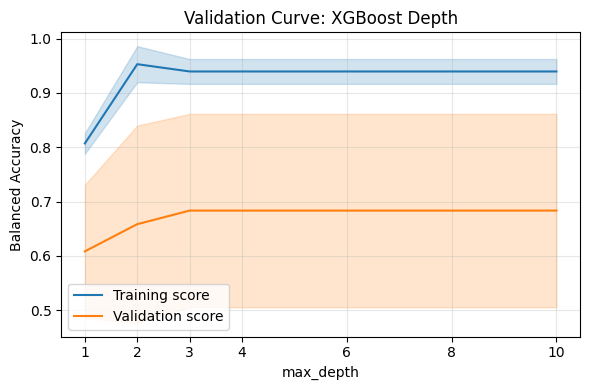

In [20]:
from sklearn.model_selection import StratifiedKFold, validation_curve

def validation_curve_over_depth(X, y, cv_splits=5, random_state=0):
    """
    Plots a validation curve (train vs. validation balanced_accuracy)
    for XGBClassifier(max_depth=…) across a range of depths.

    Parameters
    ----------
    X : array-like, shape=(n_samples, n_features)
    y : array-like, shape=(n_samples,)
    cv_splits : int
        Number of folds for StratifiedKFold.
    random_state : int
        Seed for reproducibility in StratifiedKFold and PCA.

    Returns
    -------
    None (just shows the plot).
    """
    # 1) Preprocess with a pipeline: scale → PCA(keep  min(20, n_samples-1, n_features)) → XGBClassifier
    n_samples, n_features = X.shape
    max_pcs = min(20, n_features, n_samples - 1)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=max_pcs, random_state=random_state)),
        ("clf", XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=random_state,
            tree_method="gpu_hist",    # or "gpu_hist" if you prefer
            n_estimators=20,       # fix #trees
            learning_rate=0.05,    # fix learning rate
            reg_lambda=1,
            alpha=1,
            # we will override max_depth in validation_curve
        ))
    ])

    # 2) Choose a range of max_depth values to test
    param_name = "clf__max_depth"
    param_range = [1, 2, 3, 4, 6, 8, 10]

    # 3) StratifiedKFold
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # 4) Compute training and validation scores
    train_scores, val_scores = validation_curve(
        estimator=pipe,
        X=X,
        y=y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring="balanced_accuracy",
        n_jobs=-1
    )

    # train_scores, val_scores each have shape (len(param_range), cv_splits)
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    val_mean   = np.mean(val_scores, axis=1)
    val_std    = np.std(val_scores, axis=1)

    # 5) Plot
    plt.figure(figsize=(6, 4))
    plt.plot(param_range, train_mean, label="Training score", color="tab:blue")
    plt.fill_between(param_range,
                     train_mean - train_std,
                     train_mean + train_std,
                     alpha=0.2, color="tab:blue")
    plt.plot(param_range, val_mean, label="Validation score", color="tab:orange")
    plt.fill_between(param_range,
                     val_mean - val_std,
                     val_mean + val_std,
                     alpha=0.2, color="tab:orange")
    plt.xlabel("max_depth")
    plt.ylabel("Balanced Accuracy")
    plt.title("Validation Curve: XGBoost Depth")
    plt.legend(loc="best")
    plt.xticks(param_range)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

mouse0, day_dict0 = next(iter(learning_signal.items()))
date0, out0 = next(iter(day_dict0.items()))
R1_0, R2_0 = out0['stim_cs1'], out0['stim_cs2']
n1, _ = R1_0.shape
n2, _ = R2_0.shape

X0 = np.vstack([R1_0, R2_0])
y0 = np.array([0]*n1 + [1]*n2, dtype=int)

validation_curve_over_depth(X0, y0, cv_splits=5, random_state=42)



In [ ]:
def cross_day_decoding_for_mouse(learning_signal, mouse):
    days = sorted(learning_signal[mouse].keys(), key=pd.to_datetime)
    results = {}

    day_data = {}
    for d in days:
        out = learning_signal[mouse][d]
        R1, R2 = out['stim_cs1'], out['stim_cs2']
        day_data[d] = {
            'R1': R1.astype(float),
            'R2': R2.astype(float)
        }

    max_neur = max(arr.shape[1] for d in days for arr in day_data[d].values())

    for d in days:
        for key in ('R1','R2'):
            arr = day_data[d][key]
            n_trials, n_neur = arr.shape
            if n_neur < max_neur:
                pad = np.full((n_trials, max_neur - n_neur), np.nan)
                day_data[d][key] = np.concatenate([arr, pad], axis=1)

    for i, train_day in enumerate(days[:-1]):
        for j, test_day in enumerate(days[i+1:], start=i+1):
            X_train = np.vstack([day_data[train_day]['R1'],
                                 day_data[train_day]['R2']])
            y_train = np.concatenate([
                np.zeros(day_data[train_day]['R1'].shape[0], dtype=int),
                np.ones(day_data[train_day]['R2'].shape[0], dtype=int)
            ])

            X_test = np.vstack([day_data[test_day]['R1'],
                                day_data[test_day]['R2']])
            y_test = np.concatenate([
                np.zeros(day_data[test_day]['R1'].shape[0], dtype=int),
                np.ones(day_data[test_day]['R2'].shape[0], dtype=int)
            ])

            if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
                results[(train_day, test_day)] = None
                continue

            scaler = StandardScaler().fit(X_train)
            Xtr = scaler.transform(X_train)
            Xte = scaler.transform(X_test)

            clf = XGBClassifier(
                tree_method='gpu_hist',
                predictor='gpu_predictor',
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=0
            )
            clf.fit(Xtr, y_train)
            acc = clf.score(Xte, y_test)
            results[(train_day, test_day)] = acc

    return results

for mouse in learning_signal:
    cd_results = cross_day_decoding_for_mouse(learning_signal, mouse)
    print(f"\n{mouse} – cross‐day R1 vs. R2 accuracies:")
    for (tr, te), acc in cd_results.items():
        if acc is None:
            print(f"  Train {tr} → Test {te}: insufficient classes")
        else:
            print(f"  Train {tr} → Test {te}: acc={acc:.3f}")



NN9 – cross‐day R1 vs. R2 accuracies:
  Train 210501 → Test 210502: acc=0.532
  Train 210501 → Test 210428: acc=0.632
  Train 210501 → Test 210429: acc=0.397
  Train 210502 → Test 210428: acc=0.368
  Train 210502 → Test 210429: acc=0.444
  Train 210428 → Test 210429: acc=0.524

NN8 – cross‐day R1 vs. R2 accuracies:
  Train 210312 → Test 210314: acc=0.276
  Train 210312 → Test 210316: acc=0.769
  Train 210312 → Test 210318: acc=0.386
  Train 210312 → Test 210320: acc=0.313
  Train 210314 → Test 210316: acc=0.577
  Train 210314 → Test 210318: acc=0.602
  Train 210314 → Test 210320: acc=0.675
  Train 210316 → Test 210318: acc=0.443
  Train 210316 → Test 210320: acc=0.639
  Train 210318 → Test 210320: acc=0.675

NN11 – cross‐day R1 vs. R2 accuracies:
  Train 210626 → Test 210627: acc=0.391
  Train 210626 → Test 210628: acc=0.580
  Train 210626 → Test 210629: acc=0.442
  Train 210627 → Test 210628: acc=0.504
  Train 210627 → Test 210629: acc=0.429
  Train 210628 → Test 210629: acc=0.584

N

# regressing stim-evoked out

In [118]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score

def remove_linear_cs_component(R1, R2, random_state=0):
    """
    Given two arrays R1 (n1 × d) and R2 (n2 × d), fit a logistic regression
    to distinguish R1 vs. R2, obtain its weight vector w, and return new arrays
    R1_new, R2_new after subtracting out the component along w.
    """
    # Stack residuals and build labels
    X = np.vstack([R1, R2])                         # shape = (n1+n2, d)
    y = np.array([0]*len(R1) + [1]*len(R2))          # 0 = R1, 1 = R2

    # Fit logistic regression on the full data to get w
    clf = LogisticRegression(
        penalty='none',    # no regularization → pure weight direction
        solver='lbfgs',
        max_iter=1000,
        random_state=random_state
    )
    clf.fit(X, y)
    w = clf.coef_.reshape(-1)
    w_norm_val = np.linalg.norm(w)
    if w_norm_val < 1e-8:
        print("WARNING: weight vector is effectively zero; skipping removal.")
        R1_new, R2_new = R1.copy(), R2.copy()
    else:
        w_norm = w / w_norm_val

        proj = (X @ w_norm)[:, None] * w_norm[None, :]  # shape = (n1+n2, d)
        X_new = X - proj

    n1 = R1.shape[0]
    R1_new = X_new[:n1, :]
    R2_new = X_new[n1:, :]

    return R1_new, R2_new


def test_separability_before_after(learning_signal, cv_splits=5, random_state=0):
    """
    For each mouse and each day in learning_signal, compute:
      - balanced‐accuracy (5‐fold CV) on R1 vs. R2 before removing CS component
      - then remove the linear CS‐predictive component from R1/R2 and recompute CV accuracy
    Returns a dict: results[mouse][date] = {
        'acc_before': float,
        'acc_after':  float
    }
    """
    results = {}
    outer_cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    for mouse, day_dict in learning_signal.items():
        results[mouse] = {}
        for date, out in day_dict.items():
            R1 = out['stim_cs1'].astype(np.float32)  # shape = (n1, d)
            R2 = out['stim_cs2'].astype(np.float32)  # shape = (n2, d)
            n1, d = R1.shape
            n2, _ = R2.shape

            if (n1 < cv_splits) or (n2 < cv_splits):
                results[mouse][date] = {'acc_before': np.nan, 'acc_after': np.nan}
                continue

            X_full = np.vstack([R1, R2])
            y_full = np.array([0]*n1 + [1]*n2)
            clf_full = LogisticRegression(
                penalty='l2',
                C=1.0,
                solver='lbfgs',
                max_iter=1000,
                random_state=random_state
            )
            scores_before = cross_val_score(
                clf_full, X_full, y_full, cv=outer_cv,
                scoring='balanced_accuracy'
            )
            acc_before = float(np.mean(scores_before))

            R1_new, R2_new = remove_linear_cs_component(R1, R2, random_state=random_state)

            X_new = np.vstack([R1_new, R2_new])
            y_new = np.array([1]*n1 + [0]*n2)
            clf_new = LogisticRegression(
                penalty='l2',
                C=1.0,
                solver='lbfgs',
                max_iter=1000,
                random_state=random_state
            )
            scores_after = cross_val_score(
                clf_new, X_new, y_new, cv=outer_cv,
                scoring='balanced_accuracy'
            )
            acc_after = float(np.mean(scores_after))

            results[mouse][date] = {
                'acc_before': acc_before,
                'acc_after':  acc_after
            }

    return results


results_orthogonal = test_separability_before_after(
    learning_signal,
    cv_splits=5,
    random_state=42
)

records = []
for mouse, day_dict in results_orthogonal.items():
    for date, vals in day_dict.items():
        records.append({
            'mouse':      mouse,
            'date':       date,
            'acc_before': vals['acc_before'],
            'acc_after':  vals['acc_after']
        })

df_orth = pd.DataFrame(records)

# Print per-mouse/day results
for mouse in df_orth['mouse'].unique():
    print(f"=== {mouse} ===")
    subset = df_orth[df_orth['mouse'] == mouse]
    for _, row in subset.iterrows():
        print(f"  {row['date']}: before = {row['acc_before']:.3f}, "
              f"after = {row['acc_after']:.3f}")
    print()

# Compute and print summary statistics
df_valid = df_orth.dropna(subset=['acc_before', 'acc_after']).copy()
mean_before = df_valid['acc_before'].mean()
mean_after  = df_valid['acc_after'].mean()
print(f"Grand mean accuracy before removal: {mean_before:.3f}")
print(f"Grand mean accuracy after  removal: {mean_after:.3f}")


=== NN9 ===
  210428: before = 0.867, after = 0.000
  210429: before = 0.785, after = 0.000
  210501: before = 0.840, after = 0.053
  210502: before = 0.550, after = 0.000

=== NN8 ===
  210312: before = 1.000, after = 0.000
  210314: before = 0.500, after = 0.000
  210316: before = 0.550, after = 0.000
  210318: before = 0.986, after = 0.039
  210320: before = 0.913, after = 0.154

=== NN11 ===
  210626: before = 0.980, after = 0.000
  210627: before = 0.978, after = 0.057
  210628: before = 0.974, after = 0.120
  210629: before = 0.950, after = 0.052

=== NN23 ===
  220416: before = 0.500, after = 0.070
  220417: before = 1.000, after = 0.000
  220418: before = 0.972, after = 0.000
  220419: before = 0.989, after = 0.000
  220420: before = 0.938, after = 0.000

=== NN28 ===
  230210: before = 0.633, after = 0.114
  230211: before = 0.567, after = 0.033
  230212: before = 0.983, after = 0.000
  230213: before = 0.975, after = 0.070
  230214: before = 0.939, after = 0.044

Grand mean a

‖w‖ = 1.1628693868449178

=== SESSION: NN9 210428 ===
After removal (single‐split) raw accuracy   = 1.0
After removal (single‐split) balanced acc   = 1.0
Confusion matrix (rows=true, cols=pred):
 [[18  0]
 [ 0 20]]
First 20 true labels:     [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
First 20 predictions:     [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]

Mean(R1_new·w) = 1.049e-15,  std = 4.737e-15
Mean(R2_new·w) = -2.026e-15,  std = 4.311e-15


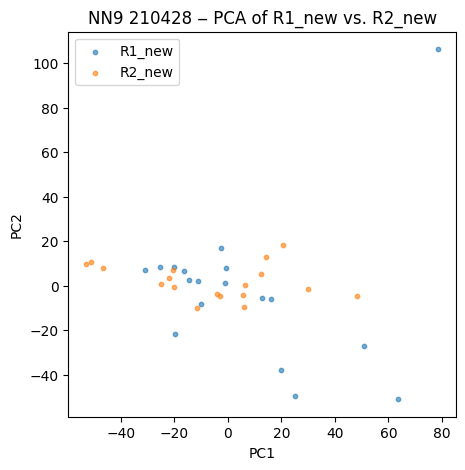

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

# ─────────── Pick one session that showed acc_after ≈ 0.035 ───────────
MOUSE = 'NN9'
DATE  = '210428'   # replace with the exact key in your dict

out = learning_signal[MOUSE][DATE]
R1 = out['stim_cs1'].astype(np.float32)    # shape = (n1, d)
R2 = out['stim_cs2'].astype(np.float32)    # shape = (n2, d)
n1, d = R1.shape
n2, _ = R2.shape

# 1) Build labels and fit the first logistic to get w
X = np.vstack([R1, R2])                     # shape = (n1+n2, d)
y = np.array([0]*n1 + [1]*n2, dtype=int)     # 0 = R1, 1 = R2

clf0 = LogisticRegression(
    penalty='none',    # no regularization so we get the pure separating w
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
clf0.fit(X, y)
w = clf0.coef_.reshape(-1)   # shape = (d,)
print("‖w‖ =", np.linalg.norm(w))

w_norm = w / np.linalg.norm(w)

# 2) Orthogonalize: subtract (X·w_norm)·w_norm from each row
proj = (X @ w_norm)[:, None] * w_norm[None, :]  # shape = (n1+n2, d)
X_new = X - proj

# Split back
R1_new = X_new[:n1, :]
R2_new = X_new[n1:, :]
y_new  = np.array([0]*n1 + [1]*n2, dtype=int)

# 3) Fit a second logistic on the _orthogonalized_ data (no CV, single split)
clf1 = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
clf1.fit(X_new, y_new)
y_pred = clf1.predict(X_new)

acc_plain = accuracy_score(y_new, y_pred)
acc_bal   = balanced_accuracy_score(y_new, y_pred)
cm = confusion_matrix(y_new, y_pred)

print(f"\n=== SESSION: {MOUSE} {DATE} ===")
print("After removal (single‐split) raw accuracy   =", acc_plain)
print("After removal (single‐split) balanced acc   =", acc_bal)
print("Confusion matrix (rows=true, cols=pred):\n", cm)
print("First 20 true labels:    ", y_new[:20])
print("First 20 predictions:    ", y_pred[:20])

# 4) Check that R1_new·w_norm and R2_new·w_norm are effectively zero
scores_R1_new = R1_new @ w_norm
scores_R2_new = R2_new @ w_norm
print(f"\nMean(R1_new·w) = {scores_R1_new.mean():.3e},  std = {scores_R1_new.std():.3e}")
print(f"Mean(R2_new·w) = {scores_R2_new.mean():.3e},  std = {scores_R2_new.std():.3e}")

# 5) Quick 2D PCA to visualize overlap
subset_size = min(n1, n2, 200)  # plot at most 200 points from each class for clarity
idx1 = np.random.RandomState(0).choice(n1, subset_size, replace=False)
idx2 = np.random.RandomState(0).choice(n2, subset_size, replace=False)

X_vis = np.vstack([R1_new[idx1, :], R2_new[idx2, :]])
y_vis = np.array([0]*subset_size + [1]*subset_size)

pca2 = PCA(n_components=2, random_state=0)
Z = pca2.fit_transform(X_vis)

plt.figure(figsize=(5, 5))
plt.scatter(Z[y_vis==0, 0], Z[y_vis==0, 1], c='C0', label='R1_new', alpha=0.6, s=10)
plt.scatter(Z[y_vis==1, 0], Z[y_vis==1, 1], c='C1', label='R2_new', alpha=0.6, s=10)
plt.legend()
plt.title(f"{MOUSE} {DATE} ‒ PCA of R1_new vs. R2_new")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

